In [130]:
import os
import sys
import numpy as np
import pickle
import mne
import scipy.io
from scipy.stats import mannwhitneyu, norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


dirs = {"out": r"C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\results",
        "eeg": r"C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data",
        "behav": r"C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\behav_data",
        "main": r"C:\Users\victo\Desktop\MRes\25MResButler\250129pilot"}

con = ['K01', 'K02', 'K03', 'K04', 'K05']
AD = ['K06','K07', 'K08', 'K09', 'K10']

subjects = con + AD
participants = con + AD

colour_con = ['#525252', '#969696', "#737373", '#252525','#bdbdbd']
colour_AD = ['#2171b5', '#c6dbef', '#9ecae1', '#4292c6', '#08306b']
colour_new = ['#807dba','#bcbddc','#9e9ac8', '#6a51a3', '#54278f']
colour_img = ['#fec44f']
colour_cat = ['#ec7014']
colour_supracat = ['#993404']

ch_names = ['Fp1','Fz','F3','F7','F9','FC5','FC1','C3','T7','CP5','CP1','Pz','P3','P7','P9','O1','Oz','O2','P10','P8','P4','CP2','CP6','T8','C4','FC2','FC6','F10','F8','F4','Fp2']

fron_ch = ['Fz', 'F3', 'F4']
cen_ch = ['C3', 'C4'] #demirayak 2023 paitel 2021
par_ch = ['Pz', 'P3', 'P4'] #P300
occ_ch = ['Oz']


In [113]:
def find_local_peak(signal, min_neighbors=3, max_neighbors=5):
    for idx in range(max_neighbors, len(signal) - max_neighbors):
        for k in range(min_neighbors, max_neighbors + 1):
            left_mean = np.mean(signal[idx - k:idx])
            right_mean = np.mean(signal[idx + 1:idx + k + 1])
            if signal[idx] > left_mean and signal[idx] > right_mean:
                return idx
    return np.argmax(signal)  

def extract_p300(erp, times, window=(200, 600)):
    start_idx = np.argmin(np.abs(times - window[0]))
    end_idx = np.argmin(np.abs(times - window[1]))

    window_data = erp[start_idx:end_idx]

    
    local_peak_idx = find_local_peak(window_data)
    peak_amplitude = window_data[local_peak_idx]
    peak_latency = times[start_idx + local_peak_idx]
    mean_amplitude = np.mean(window_data)

    return mean_amplitude, peak_latency, peak_amplitude

In [114]:
def mwu_with_r(group1, group2, name="Comparison"):
    u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided', method="auto")

    n1, n2 = len(group1), len(group2)
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (u_stat - mean_U) / std_U
    r = z / np.sqrt(n1 + n2)

    print(f"{name}:\n r={r:.4f}, U={u_stat}, p={p_val:.4f}")
    
    return r, u_stat, p_val

# Frontal channels

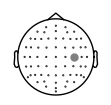

(<matplotlib.image.AxesImage at 0x1d2806408c0>, None)

In [156]:
import numpy as np
import mne

# Load standard montage and create dummy info
montage = mne.channels.make_standard_montage('biosemi64')
ch_names = montage.ch_names
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage)

# Create dummy data: all zeros (no actual data needed)
data = np.zeros(len(ch_names))

fron_ch = ['C4']

# Create mask
mask = np.array([[ch in fron_ch for ch in ch_names]]).T

# Plot topomap highlighting channels
mne.viz.plot_topomap(
    data,
    pos=info,
    names=None,
    mask=mask,
    mask_params=dict(
        marker='o',
        markerfacecolor='gray',
        markersize=3,
        markeredgewidth=3,
        markeredgecolor='gray',
        
    ),
    contours=0,
    cmap='Greys',
)


In [71]:
def get_data(subject, dirs, n_runs=8): 
    eeg_path = os.path.join(dirs["eeg"], subject)
    behav_path = os.path.join(dirs["behav"], subject)

    eeg = []
    labels = []
    image_nr_list = []
    rt_list = []
    responded_list= []
    
    for run in range(n_runs):
        mat_file = 'run{:02d}_eeg.mat'.format(run+1)
        mat_path = os.path.join(behav_path, mat_file)
        mat_data = scipy.io.loadmat(mat_path, simplify_cells=True)

        trial_df = pd.DataFrame(mat_data['results']['trial'])
        image_nr = trial_df['image_nr'].values
        rt = trial_df['RT'].values
        responded = trial_df['responded'].values

        eeg_filename = '{}_b{}.vhdr'.format(subject.lower(), run+1)
        eeg_file = os.path.join(eeg_path, eeg_filename)

        # Load EEG
        raw = mne.io.read_raw_brainvision(eeg_file, preload=True)
        raw.filter(l_freq=0.1, h_freq=40) 
        #raw.resample(sfreq = 50)
        events, event_id = mne.events_from_annotations(raw)
        raw.pick_types(eeg=True)

        img_events = events[np.isin(events[:, 2],[4,8])]
        exp_mask = image_nr < 65
        
        try:
            events_oi = img_events[exp_mask]
        except IndexError:
            print('Error: no events found')
            continue 

        images_oi = image_nr[exp_mask]

        epochs = mne.Epochs(
            raw, events_oi, tmin=-0.2, tmax=1,
            baseline=(None, 0), preload=True, reject_by_annotation=False, reject=None, picks=fron_ch  # Change accordingly for other ERPs
        )

        eeg_ = epochs.get_data()

        if eeg_.shape[0] != len(events_oi):
            print('Error: epochs were dropped. Handle it')
            break

        eeg.append(eeg_)
        labels.append(images_oi)

        rt_list.append(rt)
        responded_list.append(responded)
        image_nr_list.append(image_nr)


        channels = channels if 'channels' in locals() else epochs.ch_names
        times = times if 'times' in locals() else epochs.times

    eeg = np.concatenate(eeg, axis=0)
    labels = np.concatenate(labels, axis =0)

    n_trials, n_chans, n_times = eeg.shape

    image_nr = np.concatenate(image_nr_list, axis = 0)
    rt = np.concatenate(rt_list, axis = 0)
    responded = np.concatenate(responded_list, axis = 0)

    n_bl = np.sum(times <=0)
    bl_mean = np.array([[np.mean(eeg[x,y,:n_bl]) for y in range(n_chans)] for x in range(n_trials)])
    bl_std = np.array([[np.std(eeg[x,y,:n_bl]) for y in range(n_chans)] for x in range(n_trials)])
    eeg = np.array([[(eeg[x,y,:] - bl_mean[x,y]) / bl_std[x,y] for y in range(n_chans)] for x in range(n_trials)])

    labels_unique, labels_count = np.unique(labels, return_counts=True)
    n_imgs = len(labels_unique)
    n_reps = max(labels_count)

    _, n_chans, n_times = eeg.shape

    eeg_data = np.full((n_imgs, n_reps, n_chans, n_times), np.nan)
    for i,img in enumerate(labels_unique):
        im_mask = labels == img
        eeg_data[i] = eeg[im_mask]
    
    out_dict = {
                'eeg': eeg_data,
                'img': labels_unique,
                'chans': channels,
                'times': times,
                'subject': subject
    }

    behav_data = {'subject': subject,
                  'rt': rt, 
                  'responded': responded, 
                  'labels': image_nr}
    
    return(out_dict, behav_data)

In [72]:
out_dict = []
behav_data = []

for participant in participants:
    data, behav = get_data(participant, dirs)
    out_dict.append(data)
    behav_data.append(behav)

Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b1.vhdr...
Setting channel info structure...
Reading 0 ... 383359  =      0.000 ...   383.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b2.vhdr...
Setting channel info structure...
Reading 0 ... 380519  =      0.000 ...   380.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b3.vhdr...
Setting channel info structure...
Reading 0 ... 382059  =      0.000 ...   382.059 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379139  =      0.000 ...   379.139 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b5.vhdr...
Setting channel info structure...
Reading 0 ... 385359  =      0.000 ...   385.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b6.vhdr...
Setting channel info structure...
Reading 0 ... 384459  =      0.000 ...   384.459 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b7.vhdr...
Setting channel info structure...
Reading 0 ... 389459  =      0.000 ...   389.459 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b8.vhdr...
Setting channel info structure...
Reading 0 ... 390079  =      0.000 ...   390.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b1.vhdr...
Setting channel info structure...
Reading 0 ... 474899  =      0.000 ...   474.899 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b2.vhdr...
Setting channel info structure...
Reading 0 ... 365079  =      0.000 ...   365.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b3.vhdr...
Setting channel info structure...
Reading 0 ... 375619  =      0.000 ...   375.619 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b4.vhdr...
Setting channel info structure...
Reading 0 ... 371239  =      0.000 ...   371.239 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b5.vhdr...
Setting channel info structure...
Reading 0 ... 375519  =      0.000 ...   375.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b6.vhdr...
Setting channel info structure...
Reading 0 ... 382699  =      0.000 ...   382.699 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b7.vhdr...
Setting channel info structure...
Reading 0 ... 374099  =      0.000 ...   374.099 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b8.vhdr...
Setting channel info structure...
Reading 0 ... 372199  =      0.000 ...   372.199 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b1.vhdr...
Setting channel info structure...
Reading 0 ... 443919  =      0.000 ...   443.919 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b2.vhdr...
Setting channel info structure...
Reading 0 ... 376659  =      0.000 ...   376.659 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b3.vhdr...
Setting channel info structure...
Reading 0 ... 383679  =      0.000 ...   383.679 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b4.vhdr...
Setting channel info structure...
Reading 0 ... 377499  =      0.000 ...   377.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b5.vhdr...
Setting channel info structure...
Reading 0 ... 380359  =      0.000 ...   380.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b6.vhdr...
Setting channel info structure...
Reading 0 ... 380479  =      0.000 ...   380.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b7.vhdr...
Setting channel info structure...
Reading 0 ... 379299  =      0.000 ...   379.299 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b8.vhdr...
Setting channel info structure...
Reading 0 ... 427159  =      0.000 ...   427.159 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b1.vhdr...
Setting channel info structure...
Reading 0 ... 415479  =      0.000 ...   415.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b2.vhdr...
Setting channel info structure...
Reading 0 ... 377059  =      0.000 ...   377.059 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b3.vhdr...
Setting channel info structure...
Reading 0 ... 378599  =      0.000 ...   378.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379779  =      0.000 ...   379.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b5.vhdr...
Setting channel info structure...
Reading 0 ... 386959  =      0.000 ...   386.959 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b6.vhdr...
Setting channel info structure...
Reading 0 ... 379399  =      0.000 ...   379.399 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b7.vhdr...
Setting channel info structure...
Reading 0 ... 382079  =      0.000 ...   382.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b8.vhdr...
Setting channel info structure...
Reading 0 ... 382279  =      0.000 ...   382.279 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b1.vhdr...
Setting channel info structure...
Reading 0 ... 382339  =      0.000 ...   382.339 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b2.vhdr...
Setting channel info structure...
Reading 0 ... 390399  =      0.000 ...   390.399 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b3.vhdr...
Setting channel info structure...
Reading 0 ... 379719  =      0.000 ...   379.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b4.vhdr...
Setting channel info structure...
Reading 0 ... 381719  =      0.000 ...   381.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b5.vhdr...
Setting channel info structure...
Reading 0 ... 382659  =      0.000 ...   382.659 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b6.vhdr...
Setting channel info structure...
Reading 0 ... 379599  =      0.000 ...   379.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b7.vhdr...
Setting channel info structure...
Reading 0 ... 377039  =      0.000 ...   377.039 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b8.vhdr...
Setting channel info structure...
Reading 0 ... 377419  =      0.000 ...   377.419 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b1.vhdr...
Setting channel info structure...
Reading 0 ... 406119  =      0.000 ...   406.119 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b2.vhdr...
Setting channel info structure...
Reading 0 ... 386859  =      0.000 ...   386.859 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b3.vhdr...
Setting channel info structure...
Reading 0 ... 377539  =      0.000 ...   377.539 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b4.vhdr...
Setting channel info structure...
Reading 0 ... 397079  =      0.000 ...   397.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b5.vhdr...
Setting channel info structure...
Reading 0 ... 388759  =      0.000 ...   388.759 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b6.vhdr...
Setting channel info structure...
Reading 0 ... 380639  =      0.000 ...   380.639 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b7.vhdr...
Setting channel info structure...
Reading 0 ... 383179  =      0.000 ...   383.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b8.vhdr...
Setting channel info structure...
Reading 0 ... 383179  =      0.000 ...   383.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b1.vhdr...
Setting channel info structure...
Reading 0 ... 374879  =      0.000 ...   374.879 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b2.vhdr...
Setting channel info structure...
Reading 0 ... 383679  =      0.000 ...   383.679 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b3.vhdr...
Setting channel info structure...
Reading 0 ... 357379  =      0.000 ...   357.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b4.vhdr...
Setting channel info structure...
Reading 0 ... 385139  =      0.000 ...   385.139 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b5.vhdr...
Setting channel info structure...
Reading 0 ... 380779  =      0.000 ...   380.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b6.vhdr...
Setting channel info structure...
Reading 0 ... 378239  =      0.000 ...   378.239 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b7.vhdr...
Setting channel info structure...
Reading 0 ... 379719  =      0.000 ...   379.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b8.vhdr...
Setting channel info structure...
Reading 0 ... 215759  =      0.000 ...   215.759 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopba

C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b1.vhdr...
Setting channel info structure...
Reading 0 ... 391179  =      0.000 ...   391.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b2.vhdr...
Setting channel info structure...
Reading 0 ... 447079  =      0.000 ...   447.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b3.vhdr...
Setting channel info structure...
Reading 0 ... 383499  =      0.000 ...   383.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b4.vhdr...
Setting channel info structure...
Reading 0 ... 375859  =      0.000 ...   375.859 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b5.vhdr...
Setting channel info structure...
Reading 0 ... 382979  =      0.000 ...   382.979 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b6.vhdr...
Setting channel info structure...
Reading 0 ... 391619  =      0.000 ...   391.619 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b7.vhdr...
Setting channel info structure...
Reading 0 ... 363299  =      0.000 ...   363.299 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b8.vhdr...
Setting channel info structure...
Reading 0 ... 375479  =      0.000 ...   375.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b1.vhdr...
Setting channel info structure...
Reading 0 ... 403519  =      0.000 ...   403.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b2.vhdr...
Setting channel info structure...
Reading 0 ... 380499  =      0.000 ...   380.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b3.vhdr...
Setting channel info structure...
Reading 0 ... 387499  =      0.000 ...   387.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379939  =      0.000 ...   379.939 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b5.vhdr...
Setting channel info structure...
Reading 0 ... 381079  =      0.000 ...   381.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b6.vhdr...
Setting channel info structure...
Reading 0 ... 374179  =      0.000 ...   374.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b7.vhdr...
Setting channel info structure...
Reading 0 ... 378639  =      0.000 ...   378.639 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b8.vhdr...
Setting channel info structure...
Reading 0 ... 373779  =      0.000 ...   373.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b1.vhdr...
Setting channel info structure...
Reading 0 ... 386599  =      0.000 ...   386.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b2.vhdr...
Setting channel info structure...
Reading 0 ... 379199  =      0.000 ...   379.199 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b3.vhdr...
Setting channel info structure...
Reading 0 ... 364699  =      0.000 ...   364.699 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b4.vhdr...
Setting channel info structure...
Reading 0 ... 372379  =      0.000 ...   372.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b5.vhdr...
Setting channel info structure...
Reading 0 ... 376379  =      0.000 ...   376.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b6.vhdr...
Setting channel info structure...
Reading 0 ... 373799  =      0.000 ...   373.799 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\690268493.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
1 bad epochs dropped
Error: epochs were dropped. Handle it


## Comparing channels

In [115]:
import mne, os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

erps = {}
times = np.linspace(-200, 1000, 1201)

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    labels = data['img']
    ch_names = data['chans']
    if eeg_data.shape[0] == 0:
        continue

    erp = np.mean(eeg_data, axis=(0,1)) 

    erps[participant] = erp 

ch_erp = np.mean([erps[p] for p in participants], axis=0) 
con_ch = np.mean([erps[p] for p in con], axis=0)
AD_ch = np.mean([erps[p] for p in AD], axis=0)

In [188]:
ch_erp

array([-0.02558169, -0.02335776, -0.02110841, ...,  0.14016717,
        0.14524201,  0.15034454], shape=(1201,))

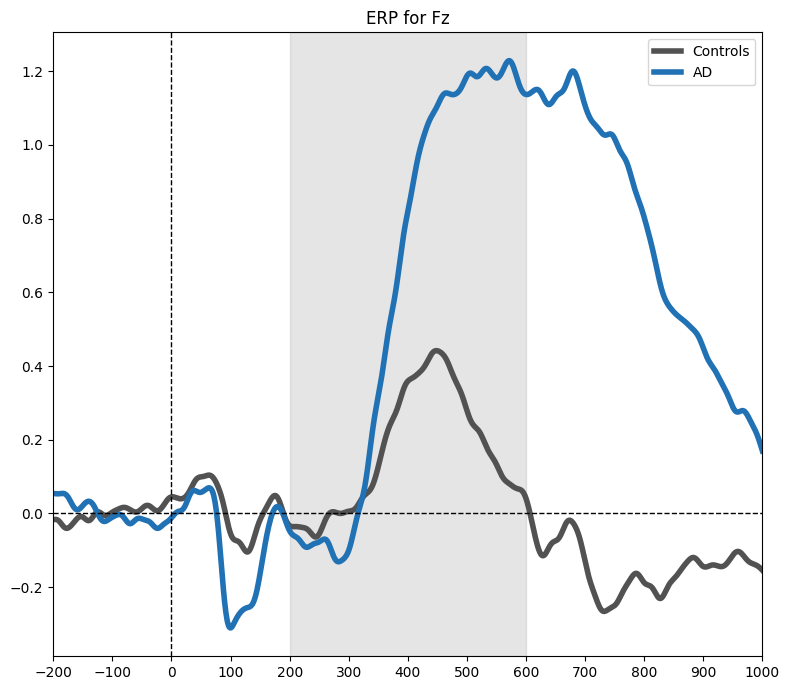

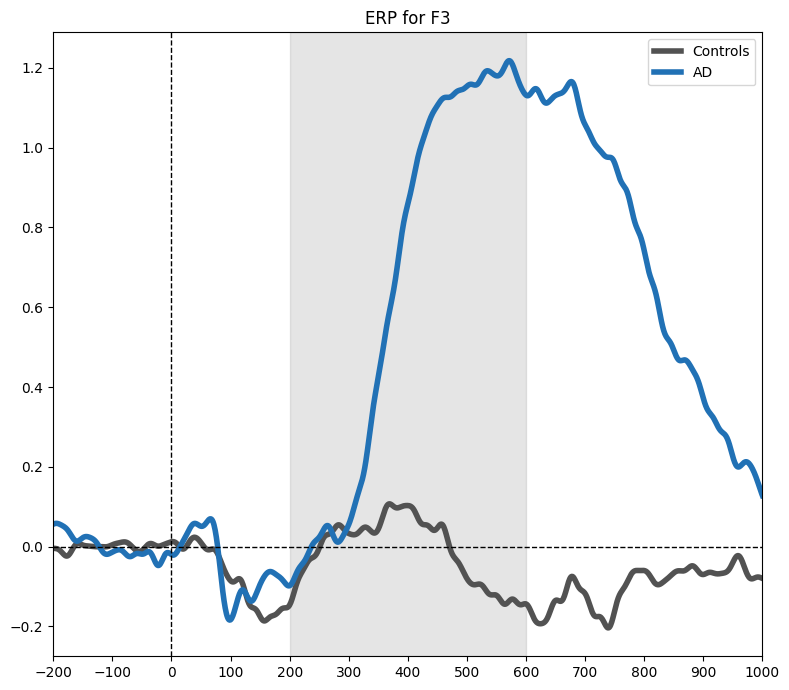

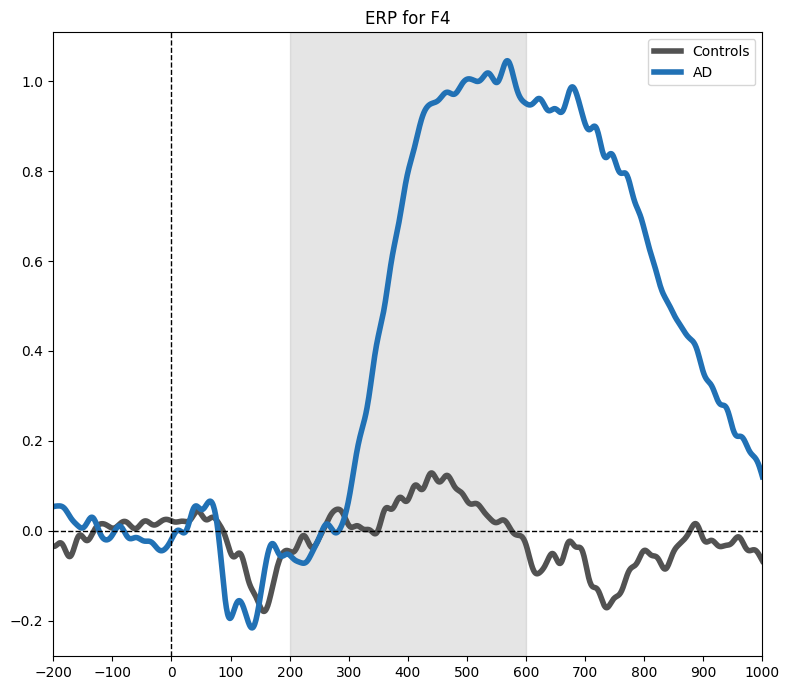

In [118]:
n_chans = ch_erp.shape[0]

for ch in range(n_chans):
    plt.figure(figsize=(8, 7))
    #plt.plot(times, ch_erp[ch], label='All', color='black', linewidth=2)
    plt.plot(times, con_ch[ch], label='Controls', color=colour_con[0], linewidth=4)
    plt.plot(times, AD_ch[ch], label='AD', color=colour_AD[0], linewidth=4)
    plt.xlim(-200,1000)
    plt.axvspan(200, 600, color='grey', alpha=0.2)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.title(f'ERP for {ch_names[ch]}')
    plt.legend()
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200, 1001, 100))
    plt.tight_layout()

## Grand Average

In [157]:
import mne, os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

erps = {}
times = np.linspace(-200, 1000, 1201)

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    labels = data['img']
    ch_names = data['chans']
    if eeg_data.shape[0] == 0:
        continue

    erp = np.mean(eeg_data, axis=(1,2)) 

    erps[participant] = erp 

for key, data in erps.items():
    participant = key
    mean_erp = np.mean(data, axis=0)
    erps[participant] = mean_erp

In [158]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    amp_mean, lat, amp_peak = extract_p300(erps[participant], times, window=(200,600))
    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)
    
con_amp_mean = np.array(con_amp_mean)
con_lat = np.array(con_lat)
con_amp_peak = np.array(con_amp_peak)


mean_amp_mean = np.mean(con_amp_mean)
mean_lat = np.mean(con_lat)
mean_amp_peak = np.mean(con_amp_peak)


std_amp_mean = np.std(con_amp_mean)
std_lat = np.std(con_lat)
std_amp_peak = np.std(con_amp_peak)

print("Control Group P300 Analysis:")
print(f"Mean Amplitude: {mean_amp_mean:.4f} ± {std_amp_mean:.4f} µV")
print(f"Peak Latency: {mean_lat:.4f} ± {std_lat:.4f} ms")
print(f"Peak Amplitude: {mean_amp_peak:.4f} ± {std_amp_peak:.4f} µV")

Control Group P300 Analysis:
Mean Amplitude: -0.1216 ± 0.3856 µV
Peak Latency: 236.8000 ± 27.4547 ms
Peak Amplitude: 0.2395 ± 0.1663 µV


In [127]:
AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    amp_mean, lat, amp_peak = extract_p300(erps[participant], times, window=(200,600))
    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)
    
AD_amp_mean = np.array(AD_amp_mean)
AD_lat = np.array(AD_lat)
AD_amp_peak = np.array(AD_amp_peak)

mean_amp_mean_AD = np.mean(AD_amp_mean)
mean_lat_AD = np.mean(AD_lat)
mean_amp_peak_AD = np.mean(AD_amp_peak)


std_amp_mean_AD = np.std(AD_amp_mean)
std_lat_AD = np.std(AD_lat)
std_amp_peak_AD = np.std(AD_amp_peak)

print("AD Group P300 Analysis:")
print(f"Mean Amplitude: {mean_amp_mean_AD:.4f} ± {std_amp_mean_AD:.4f} µV")
print(f"Peak Latency: {mean_lat_AD:.4f} ± {std_lat_AD:.4f} ms")
print(f"Peak Amplitude: {mean_amp_peak_AD:.4f} ± {std_amp_peak_AD:.4f} µV")

AD Group P300 Analysis:
Mean Amplitude: 0.6255 ± 1.6081 µV
Peak Latency: 312.0000 ± 104.8790 ms
Peak Amplitude: 0.8519 ± 2.4933 µV


In [128]:
print("Individual con P300 Latencies - grand avg")
print(np.array(con_lat))
print("Individual AD P300 Latencies - grand avg")
print(np.array(AD_lat))

Individual con P300 Latencies - grand avg
[214. 273. 205. 230. 278.]
Individual AD P300 Latencies - grand avg
[504. 256. 341. 246. 213.]


In [129]:
mwu_p300ampmean = mwu_with_r(con_amp_mean, AD_amp_mean, name="P300 Mean Amplitude")
mwu_p300lat = mwu_with_r(con_lat, AD_lat, name="P300 Latency")
mwu_p300peak = mwu_with_r(con_amp_peak, AD_amp_peak, name="P300 Local Peak")

P300 Mean Amplitude:
 r=-0.0330, U=12.0, p=1.0000
P300 Latency:
 r=-0.2973, U=8.0, p=0.4206
P300 Local Peak:
 r=0.1651, U=15.0, p=0.6905


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\1500127469.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


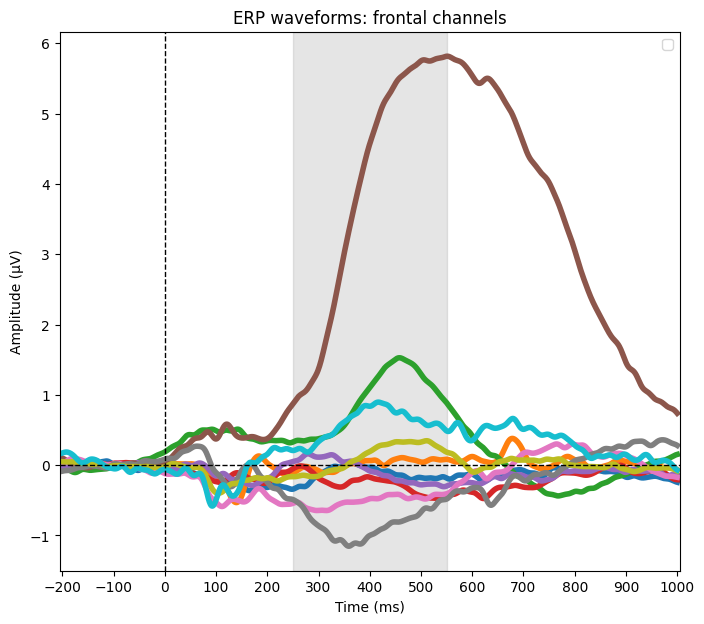

In [131]:
con_erp, AD_erp = [], []

for participant in con:
    con_erp.append(erps[participant])

for participant in AD:
    AD_erp.append(erps[participant])

con_erp = np.array(con_erp) #still maintaining participant structure
AD_erp = np.array(AD_erp)

con_mean = np.mean(con_erp, axis=(0,1)) #mean across participants and images
AD_mean = np.mean(AD_erp, axis=(0,1)) 

plt.figure(figsize=(8, 7))
plt.plot(times, con_erp.T, alpha=1, linewidth=4)
plt.plot(times, AD_erp.T, alpha=1, linewidth=4)
plt.axvspan(250, 550, color='grey', alpha=0.2)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xticks(np.arange(-200, 1001, 100))
plt.xlim(-205, 1005)
plt.title("ERP waveforms: frontal channels")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.show()

## Cats

In [132]:
categories = {
    "Faces": range(1, 17),       
    "Animals": range(17, 33),    
    "Places": range(33, 49),     
    "Objects": range(49, 65)   
}
categories_list = ["Faces", "Animals", "Places", "Objects"]

erps = {}

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    n_imgs = eeg_data.shape[0]
    labels = data['img']
    ch_names = data['chans']

    for category, indices in categories.items():
        n_imgs = len(indices)
        img_mask = np.isin(labels, indices)
        eeg_cat = eeg_data[img_mask]
        #print(eeg_cat.shape)
        erp = np.mean(eeg_cat, axis=(1,2))
        #print(erp.shape)
        erps[(participant, category)] = erp


In [133]:
cat_erps = {}

for key, data in erps.items():
    participant, category = key
    mean_erp = np.mean(data, axis=0)
    cat_erps[(participant, category)] = mean_erp # dictionary with keys for p and cats, then array with 1D already averaged across images

cat_con, cat_AD = {}, {}

for p in con: 
    cat_con[p] = {}
    for cat in categories_list:
        cat_con[p][cat] = cat_erps[(p, cat)]

for p in AD:
    cat_AD[p] = {}
    for cat in categories_list:
        cat_AD[p][cat] = cat_erps[(p, cat)]
    

Extract P300 information (change cat accordingly)

In [137]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    cat_erp = cat_con[participant]["Animals"]
    amp_mean, lat, amp_peak = extract_p300(cat_erp, times, window=(200,600))

    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)

AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    cat_erp = cat_AD[participant]['Animals']
    amp_mean, lat, amp_peak = extract_p300(cat_erp, times, window=(200,600))

    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)

In [138]:
print("Control Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(con_amp_mean):.4f} ± {np.std(con_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(con_lat):.4f} ± {np.std(con_lat):.4f} ms")
print(f"  Peak Amplitude : {np.mean(con_amp_peak):.4f} ± {np.std(con_amp_peak):.4f} µV")
print()
print("Individual Control Group P300 Latencies:")
print(np.array(con_lat))
print("Individual Control Group Peak Amplitudes:")
print(np.array(con_amp_peak))
print("\n" + "-"*40 + "\n")

print("AD Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(AD_amp_mean):.4f} ± {np.std(AD_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(AD_lat):.4f} ± {np.std(AD_lat):.4f} ms")
print(f"  Peak Amplitude : {np.mean(AD_amp_peak):.4f} ± {np.std(AD_amp_peak):.4f} µV")
print()
print("Individual AD Group P300 Latencies:")
print(np.array(AD_lat))
print("Individual AD Group Peak Amplitudes:")
print(np.array(AD_amp_peak))
print("\n" + "-"*40 + "\n")



Control Group P300 Analysis:
  Mean Amplitude : 0.0545 ± 0.3945 µV
  Peak Latency   : 237.0000 ± 31.0548 ms
  Peak Amplitude : 0.0313 ± 0.2374 µV

Individual Control Group P300 Latencies:
[214. 275. 210. 211. 275.]
Individual Control Group Peak Amplitudes:
[-0.31751915 -0.00820611  0.39221365 -0.07304627  0.1629007 ]

----------------------------------------

AD Group P300 Analysis:
  Mean Amplitude : 0.5329 ± 1.6579 µV
  Peak Latency   : 233.6000 ± 15.9700 ms
  Peak Amplitude : -0.0676 ± 0.5343 µV

Individual AD Group P300 Latencies:
[264. 234. 222. 228. 220.]
Individual AD Group Peak Amplitudes:
[ 0.92198602 -0.69465662 -0.25872359 -0.19767769 -0.10880196]

----------------------------------------



In [139]:
mwu_n170ampmean_cat = mwu_with_r(con_amp_mean, AD_amp_mean, name="Cat P300 Mean Amplitude")
mwu_n170lat_cat = mwu_with_r(con_lat, AD_lat, name="Cat P300 Peak Latency")
mwu_n170peak_cat = mwu_with_r(con_amp_peak, AD_amp_peak, name="Cat P300 Local Peak Amplitude")

Cat P300 Mean Amplitude:
 r=-0.0330, U=12.0, p=1.0000
Cat P300 Peak Latency:
 r=-0.1651, U=10.0, p=0.6752
Cat P300 Local Peak Amplitude:
 r=0.2973, U=17.0, p=0.4206


Visualisation plots

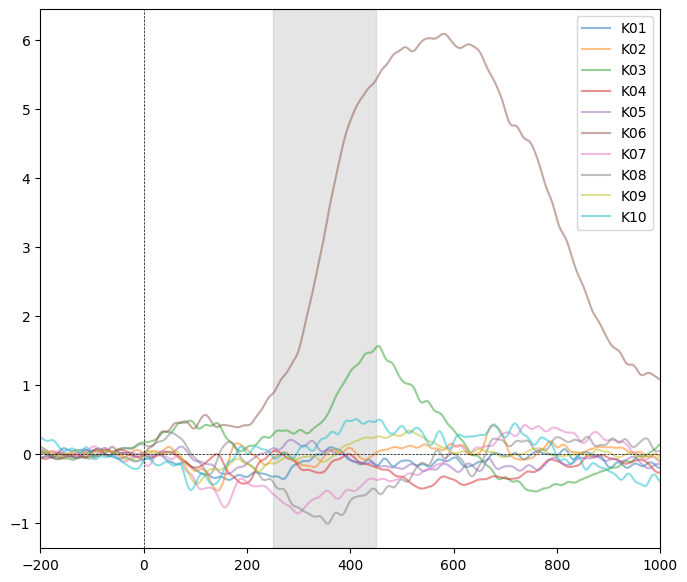

In [77]:
plt.figure(figsize=(8, 7))
for participant in con:
    plt.plot(times, cat_con[participant]['Faces'], label=participant, alpha=0.5)
for participant in AD:
    plt.plot(times, cat_AD[participant]['Faces'], label=participant, alpha=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvspan(250, 450, color='grey', alpha=0.2)
plt.legend()
plt.xlim(-200, 1000)
plt.show()

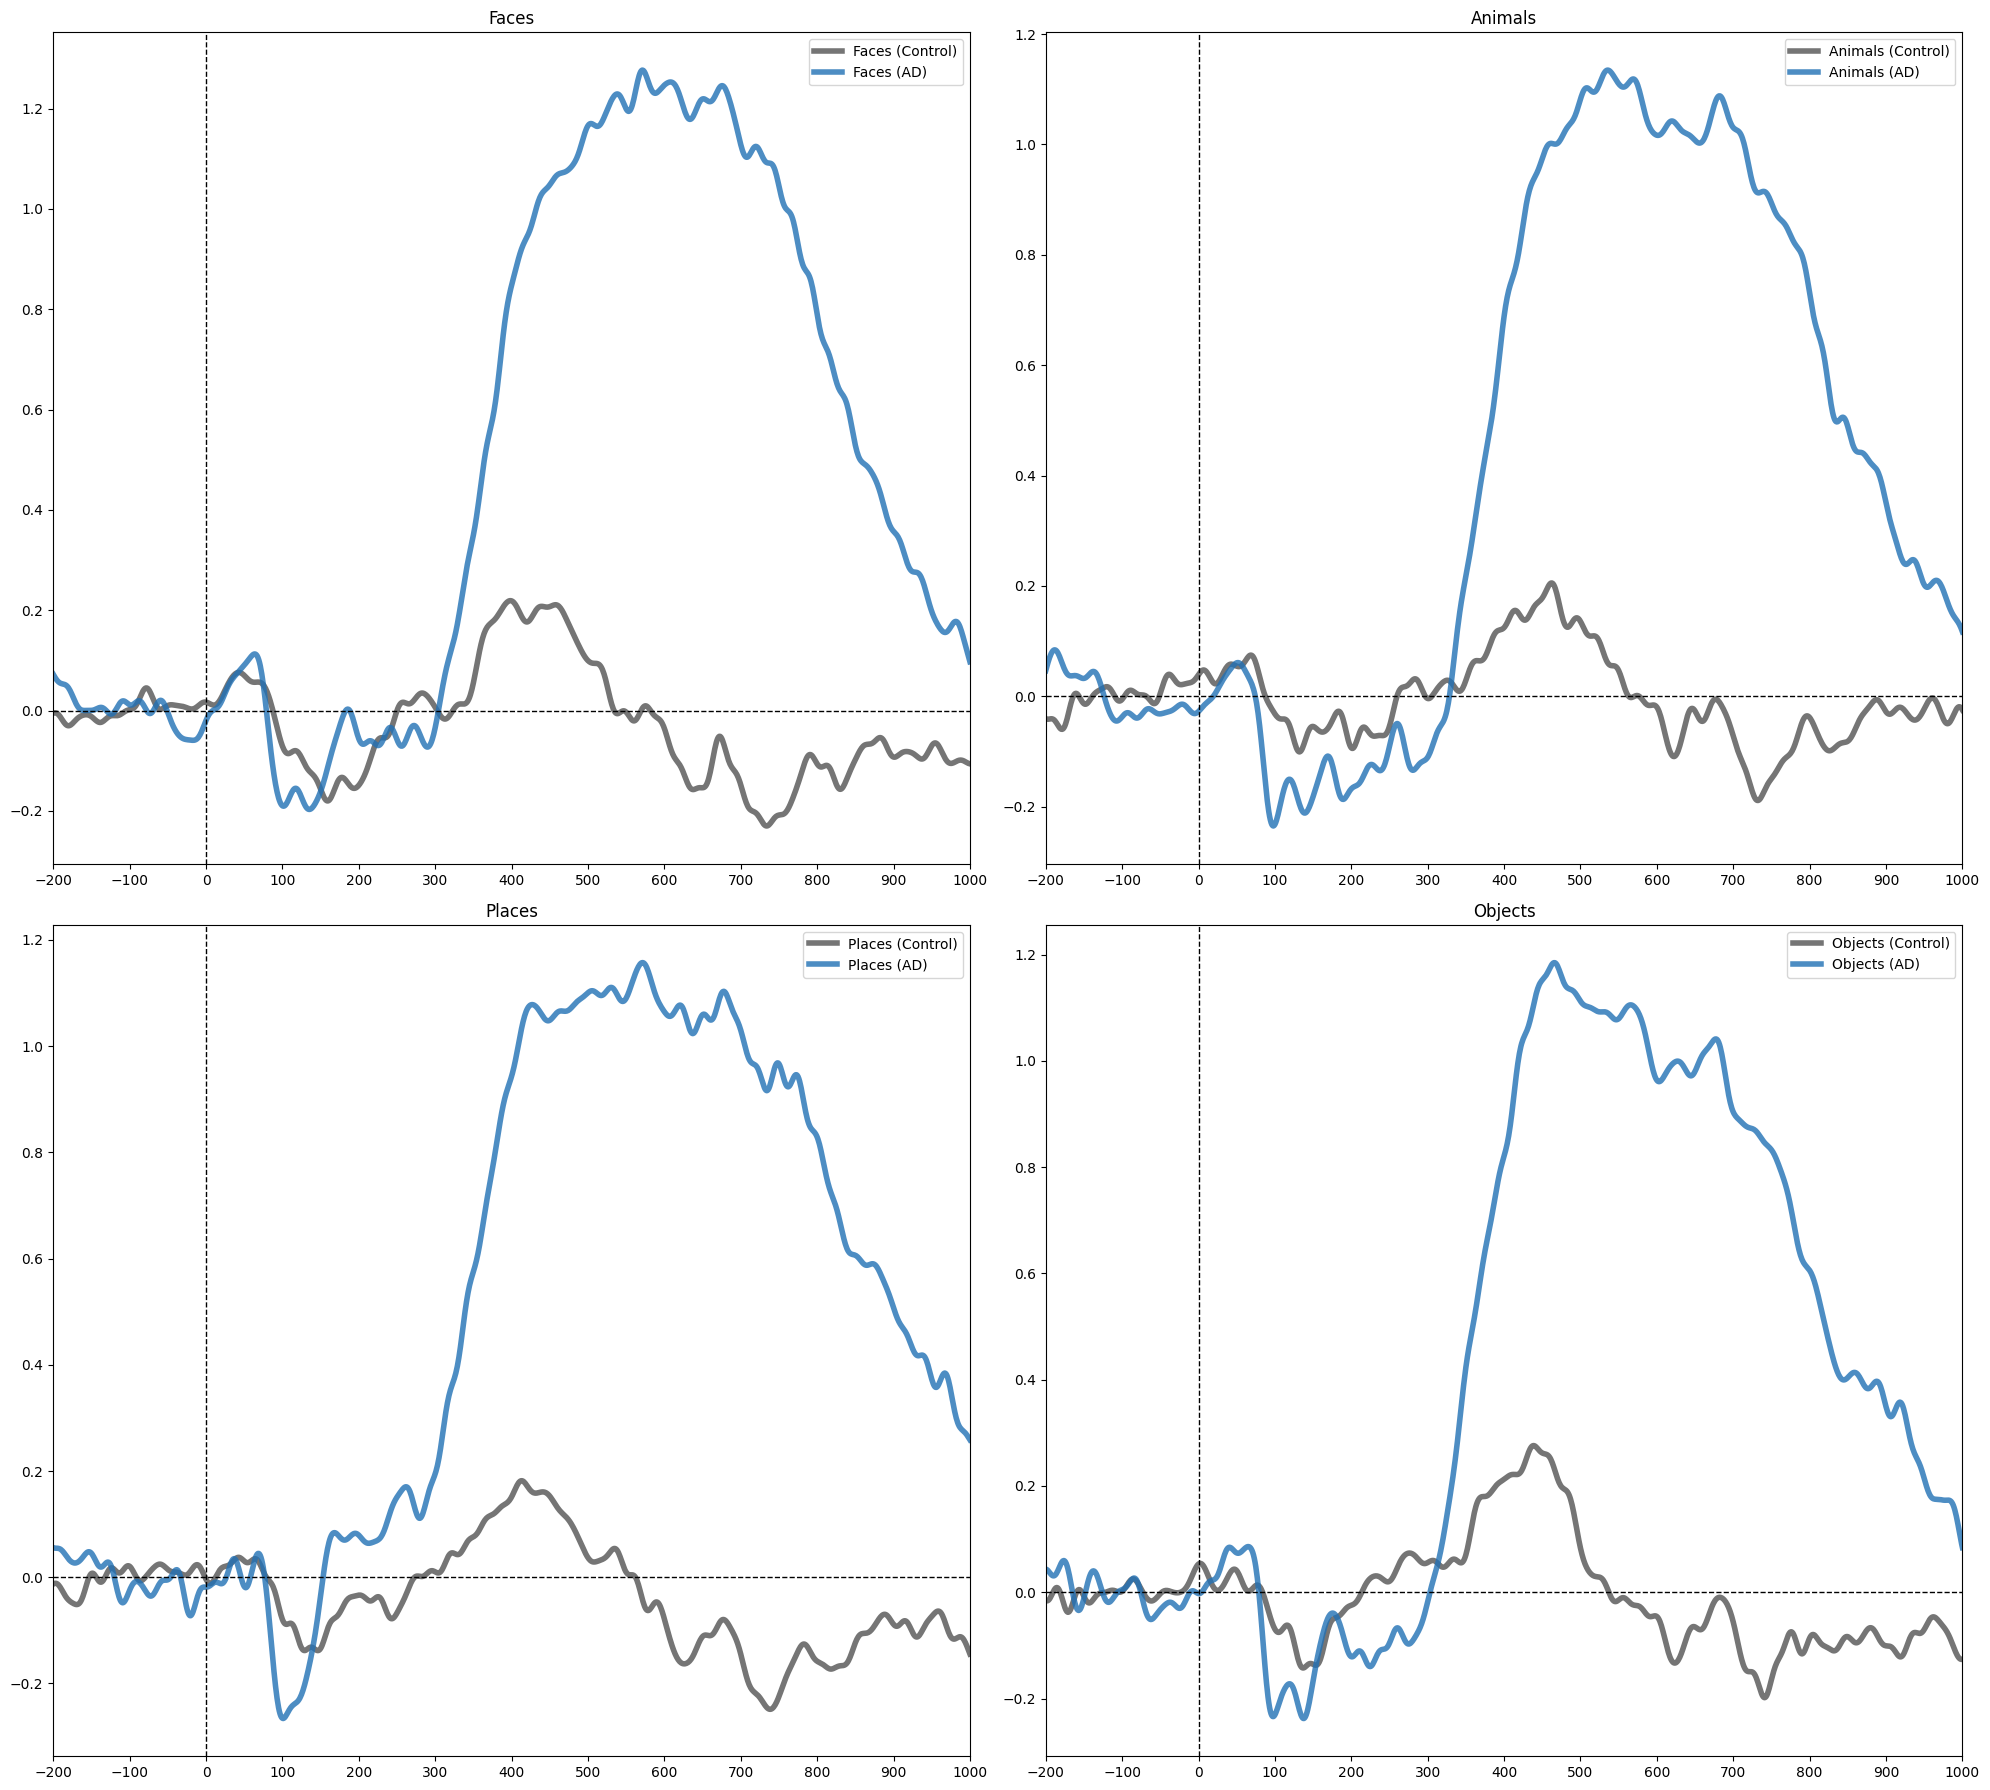

In [78]:
plt.figure(figsize=(20, 18))
for i, category in enumerate(categories_list, 1):
    con_mean = np.mean([cat_con[p][category] for p in con], axis=0)
    AD_mean = np.mean([cat_AD[p][category] for p in AD], axis=0)
    plt.subplot(2, 2, i)
    plt.plot(times, con_mean, label=f'{category} (Control)', alpha=0.8, color=colour_con[0], linewidth=4)
    plt.plot(times, AD_mean, label=f'{category} (AD)', alpha=0.8, color=colour_AD[0], linewidth=4)
    #plt.axvspan(140, 200, color='grey', alpha=0.2)
    plt.title(category)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.legend()
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200, 1001, 100))
    plt.tight_layout()

plt.show()

## Sup

In [79]:
sups = {
    "Animate": range(1, 33),       
    "Inanimate": range(33, 65),    
}
sups_list = ["Animate", "Inanimate"]

erps = {}

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    n_imgs = eeg_data.shape[0]
    labels = data['img']
    ch_names = data['chans']

    for category, indices in sups.items():
        n_imgs = len(indices)
        img_mask = np.isin(labels, indices)
        eeg_cat = eeg_data[img_mask]
        #print(eeg_cat.shape)
        erp = np.mean(eeg_cat, axis=(1,2))
        #print(erp.shape)
        erps[(participant, category)] = erp


In [80]:
sup_erps = {}

for key, data in erps.items():
    participant, category = key
    mean_erp = np.mean(data, axis=0)
    cat_erps[(participant, category)] = mean_erp # dictionary with keys for p and cats, then array with 1D already averaged across images

sup_con, sup_AD = {}, {}

for p in con: 
    sup_con[p] = {}
    for cat in sups_list:
        sup_con[p][cat] = cat_erps[(p, cat)]

for p in AD:
    sup_AD[p] = {}
    for cat in sups_list:
        sup_AD[p][cat] = cat_erps[(p, cat)]
    

Extract P300 information (change sup accordingly)

In [ ]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    sup_erp = sup_con[participant]["Animate"]
    amp_mean, lat, amp_peak = extract_p300(sup_erp, times, window=(200,500))

    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)

AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    sup_erp = sup_AD[participant]['Animate']
    amp_mean, lat, amp_peak = extract_p300(sup_erp, times, window=(200, 500))

    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)

print("Individual Control Group P300 Latencies:")
print(np.array(con_lat))
print("Individual Control Group Peak Amplitudes:")
print(np.array(con_amp_peak))
print("\n" + "-"*40 + "\n")
print("Individual AD Group P300 Latencies:")
print(np.array(AD_lat))
print("Individual AD Group Peak Amplitudes:")
print(np.array(AD_amp_peak))
print("\n" + "-"*40 + "\n")

Individual Control Group P300 Latencies:
[260. 273. 280. 260. 280.]
Individual Control Group Peak Amplitudes:
[-0.3212758   0.00618121  0.36373256 -0.00893609  0.17608562]

----------------------------------------

Individual AD Group P300 Latencies:
[449. 255. 338. 277. 265.]
Individual AD Group Peak Amplitudes:
[ 5.46282019 -0.63484161 -1.0003523  -0.11429001 -0.02290851]

----------------------------------------



In [ ]:
import numpy as np
from scipy import stats
n = len(con_lat)
mean_lat_con = np.mean(con_lat)
std_lat_con = np.std(con_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_con / np.sqrt(n))

ci_lower_con = mean_lat_con - moe
ci_upper_con = mean_lat_con + moe


print("Control Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(con_amp_mean):.4f} ± {np.std(con_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(con_lat):.4f} ± {np.std(con_lat):.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower_con:.4f}, {ci_upper_con:.4f}] ms")
print()
print(f"  Peak Amplitude : {np.mean(con_amp_peak):.4f} ± {np.std(con_amp_peak):.4f} µV")
print()



n = len(AD_lat)
mean_lat_AD = np.mean(AD_lat)
std_lat_AD = np.std(AD_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_AD / np.sqrt(n))

ci_lower_AD = mean_lat_AD - moe
ci_upper_AD = mean_lat_AD + moe

print("AD Group P300 Analysis: Grand Average in Parietal Channels")

print("AD Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(AD_amp_mean):.4f} ± {np.std(AD_amp_mean):.4f} µV")
print()
print(f"  Peak Latency   : {np.mean(AD_lat):.4f} ± {np.std(AD_lat):.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower_AD:.4f}, {ci_upper_AD:.4f}] ms")
print()
print(f"  Peak Amplitude : {np.mean(AD_amp_peak):.4f} ± {np.std(AD_amp_peak):.4f} µV")
print()
print()


Control Group P300 Analysis:
  Mean Amplitude : 0.0805 ± 0.3239 µV
  Peak Latency   : 270.6000 ± 9.0244 ms
95% CI for Peak Latency: [258.0721, 283.1279] ms

  Peak Amplitude : 0.0432 ± 0.2269 µV

AD Group P300 Analysis: Grand Average in Parietal Channels
AD Group P300 Analysis:
  Mean Amplitude : 0.3552 ± 1.4051 µV

  Peak Latency   : 316.8000 ± 72.1288 ms
95% CI for Peak Latency: [216.6692, 416.9308] ms

  Peak Amplitude : 0.7381 ± 2.3890 µV




In [86]:
mwu_n170ampmean_sup = mwu_with_r(con_amp_mean, AD_amp_mean, name="Sup P300 Mean Amplitude")
mwu_n170lat_sup = mwu_with_r(con_lat, AD_lat, name="Sup P300 Peak Latency")
mwu_n170peak_sup = mwu_with_r(con_amp_peak, AD_amp_peak, name="Sup P300 Local Peak Amplitude")

Sup P300 Mean Amplitude:
 r=0.0330, U=13.0, p=1.0000
Sup P300 Peak Latency:
 r=-0.1651, U=10.0, p=0.6742
Sup P300 Local Peak Amplitude:
 r=0.3633, U=18.0, p=0.3095


Visualisation plots

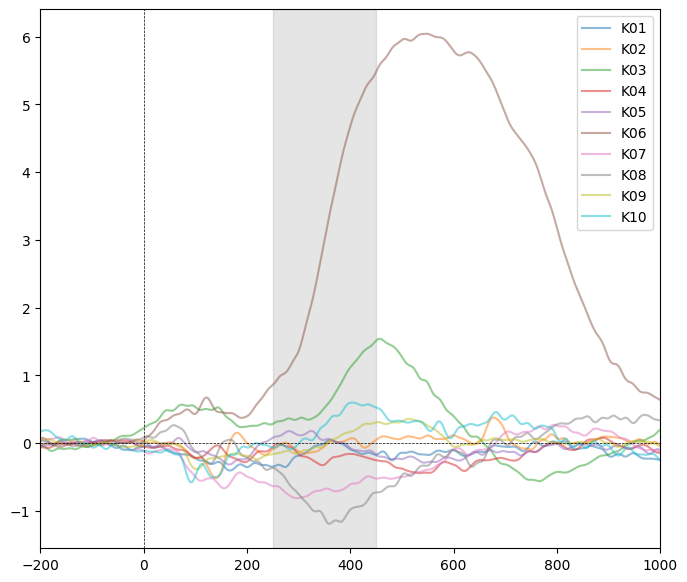

In [88]:
plt.figure(figsize=(8, 7))
for participant in con:
    plt.plot(times, sup_con[participant]['Animate'], label=participant, alpha=0.5)
for participant in AD:
    plt.plot(times, sup_AD[participant]['Animate'], label=participant, alpha=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvspan(250, 450, color='grey', alpha=0.2)
plt.legend()
plt.xlim(-200, 1000)
plt.show()

# Central channels

In [141]:
def get_data(subject, dirs, n_runs=8): 
    eeg_path = os.path.join(dirs["eeg"], subject)
    behav_path = os.path.join(dirs["behav"], subject)

    eeg = []
    labels = []
    image_nr_list = []
    rt_list = []
    responded_list= []
    
    for run in range(n_runs):
        mat_file = 'run{:02d}_eeg.mat'.format(run+1)
        mat_path = os.path.join(behav_path, mat_file)
        mat_data = scipy.io.loadmat(mat_path, simplify_cells=True)

        trial_df = pd.DataFrame(mat_data['results']['trial'])
        image_nr = trial_df['image_nr'].values
        rt = trial_df['RT'].values
        responded = trial_df['responded'].values

        eeg_filename = '{}_b{}.vhdr'.format(subject.lower(), run+1)
        eeg_file = os.path.join(eeg_path, eeg_filename)

        # Load EEG
        raw = mne.io.read_raw_brainvision(eeg_file, preload=True)
        raw.filter(l_freq=0.01, h_freq=40) #changed from 0.1 to 0.01
        #raw.resample(sfreq = 50)
        events, event_id = mne.events_from_annotations(raw)
        raw.pick_types(eeg=True)

        img_events = events[np.isin(events[:, 2],[4,8])]
        exp_mask = image_nr < 65
        
        try:
            events_oi = img_events[exp_mask]
        except IndexError:
            print('Error: no events found')
            continue 

        images_oi = image_nr[exp_mask]

        epochs = mne.Epochs(
            raw, events_oi, tmin=-0.2, tmax=1,
            baseline=(None, 0), preload=True, reject_by_annotation=False, reject=None, picks=cen_ch  # Change accordingly for other ERPs
        )

        eeg_ = epochs.get_data()

        if eeg_.shape[0] != len(events_oi):
            print('Error: epochs were dropped. Handle it')
            break

        eeg.append(eeg_)
        labels.append(images_oi)

        rt_list.append(rt)
        responded_list.append(responded)
        image_nr_list.append(image_nr)


        channels = channels if 'channels' in locals() else epochs.ch_names
        times = times if 'times' in locals() else epochs.times

    eeg = np.concatenate(eeg, axis=0)
    labels = np.concatenate(labels, axis =0)

    n_trials, n_chans, n_times = eeg.shape

    image_nr = np.concatenate(image_nr_list, axis = 0)
    rt = np.concatenate(rt_list, axis = 0)
    responded = np.concatenate(responded_list, axis = 0)

    n_bl = np.sum(times <=0)
    bl_mean = np.array([[np.mean(eeg[x,y,:n_bl]) for y in range(n_chans)] for x in range(n_trials)])
    bl_std = np.array([[np.std(eeg[x,y,:n_bl]) for y in range(n_chans)] for x in range(n_trials)])
    eeg = np.array([[(eeg[x,y,:] - bl_mean[x,y]) / bl_std[x,y] for y in range(n_chans)] for x in range(n_trials)])

    labels_unique, labels_count = np.unique(labels, return_counts=True)
    n_imgs = len(labels_unique)
    n_reps = max(labels_count)

    _, n_chans, n_times = eeg.shape

    eeg_data = np.full((n_imgs, n_reps, n_chans, n_times), np.nan)
    for i,img in enumerate(labels_unique):
        im_mask = labels == img
        eeg_data[i] = eeg[im_mask]
    
    out_dict = {
                'eeg': eeg_data,
                'img': labels_unique,
                'chans': channels,
                'times': times,
                'subject': subject
    }

    behav_data = {'subject': subject,
                  'rt': rt, 
                  'responded': responded, 
                  'labels': image_nr}
    
    return(out_dict, behav_data)

In [142]:
out_dict = []
behav_data = []

for participant in participants:
    data, behav = get_data(participant, dirs)
    out_dict.append(data)
    behav_data.append(behav)


Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b1.vhdr...
Setting channel info structure...
Reading 0 ... 383359  =      0.000 ...   383.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b2.vhdr...
Setting channel info structure...
Reading 0 ... 380519  =      0.000 ...   380.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b3.vhdr...
Setting channel info structure...
Reading 0 ... 382059  =      0.000 ...   382.059 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379139  =      0.000 ...   379.139 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b5.vhdr...
Setting channel info structure...
Reading 0 ... 385359  =      0.000 ...   385.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b6.vhdr...
Setting channel info structure...
Reading 0 ... 384459  =      0.000 ...   384.459 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b7.vhdr...
Setting channel info structure...
Reading 0 ... 389459  =      0.000 ...   389.459 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b8.vhdr...
Setting channel info structure...
Reading 0 ... 390079  =      0.000 ...   390.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b1.vhdr...
Setting channel info structure...
Reading 0 ... 474899  =      0.000 ...   474.899 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b2.vhdr...
Setting channel info structure...
Reading 0 ... 365079  =      0.000 ...   365.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b3.vhdr...
Setting channel info structure...
Reading 0 ... 375619  =      0.000 ...   375.619 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b4.vhdr...
Setting channel info structure...
Reading 0 ... 371239  =      0.000 ...   371.239 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b5.vhdr...
Setting channel info structure...
Reading 0 ... 375519  =      0.000 ...   375.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b6.vhdr...
Setting channel info structure...
Reading 0 ... 382699  =      0.000 ...   382.699 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b7.vhdr...
Setting channel info structure...
Reading 0 ... 374099  =      0.000 ...   374.099 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b8.vhdr...
Setting channel info structure...
Reading 0 ... 372199  =      0.000 ...   372.199 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b1.vhdr...
Setting channel info structure...
Reading 0 ... 443919  =      0.000 ...   443.919 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b2.vhdr...
Setting channel info structure...
Reading 0 ... 376659  =      0.000 ...   376.659 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b3.vhdr...
Setting channel info structure...
Reading 0 ... 383679  =      0.000 ...   383.679 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b4.vhdr...
Setting channel info structure...
Reading 0 ... 377499  =      0.000 ...   377.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b5.vhdr...
Setting channel info structure...
Reading 0 ... 380359  =      0.000 ...   380.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b6.vhdr...
Setting channel info structure...
Reading 0 ... 380479  =      0.000 ...   380.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b7.vhdr...
Setting channel info structure...
Reading 0 ... 379299  =      0.000 ...   379.299 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b8.vhdr...
Setting channel info structure...
Reading 0 ... 427159  =      0.000 ...   427.159 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b1.vhdr...
Setting channel info structure...
Reading 0 ... 415479  =      0.000 ...   415.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b2.vhdr...
Setting channel info structure...
Reading 0 ... 377059  =      0.000 ...   377.059 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b3.vhdr...
Setting channel info structure...
Reading 0 ... 378599  =      0.000 ...   378.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379779  =      0.000 ...   379.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b5.vhdr...
Setting channel info structure...
Reading 0 ... 386959  =      0.000 ...   386.959 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b6.vhdr...
Setting channel info structure...
Reading 0 ... 379399  =      0.000 ...   379.399 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b7.vhdr...
Setting channel info structure...
Reading 0 ... 382079  =      0.000 ...   382.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b8.vhdr...
Setting channel info structure...
Reading 0 ... 382279  =      0.000 ...   382.279 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b1.vhdr...
Setting channel info structure...
Reading 0 ... 382339  =      0.000 ...   382.339 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b2.vhdr...
Setting channel info structure...
Reading 0 ... 390399  =      0.000 ...   390.399 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b3.vhdr...
Setting channel info structure...
Reading 0 ... 379719  =      0.000 ...   379.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b4.vhdr...
Setting channel info structure...
Reading 0 ... 381719  =      0.000 ...   381.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b5.vhdr...
Setting channel info structure...
Reading 0 ... 382659  =      0.000 ...   382.659 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b6.vhdr...
Setting channel info structure...
Reading 0 ... 379599  =      0.000 ...   379.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b7.vhdr...
Setting channel info structure...
Reading 0 ... 377039  =      0.000 ...   377.039 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b8.vhdr...
Setting channel info structure...
Reading 0 ... 377419  =      0.000 ...   377.419 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b1.vhdr...
Setting channel info structure...
Reading 0 ... 406119  =      0.000 ...   406.119 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b2.vhdr...
Setting channel info structure...
Reading 0 ... 386859  =      0.000 ...   386.859 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b3.vhdr...
Setting channel info structure...
Reading 0 ... 377539  =      0.000 ...   377.539 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b4.vhdr...
Setting channel info structure...
Reading 0 ... 397079  =      0.000 ...   397.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b5.vhdr...
Setting channel info structure...
Reading 0 ... 388759  =      0.000 ...   388.759 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b6.vhdr...
Setting channel info structure...
Reading 0 ... 380639  =      0.000 ...   380.639 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b7.vhdr...
Setting channel info structure...
Reading 0 ... 383179  =      0.000 ...   383.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b8.vhdr...
Setting channel info structure...
Reading 0 ... 383179  =      0.000 ...   383.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b1.vhdr...
Setting channel info structure...
Reading 0 ... 374879  =      0.000 ...   374.879 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b2.vhdr...
Setting channel info structure...
Reading 0 ... 383679  =      0.000 ...   383.679 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b3.vhdr...
Setting channel info structure...
Reading 0 ... 357379  =      0.000 ...   357.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b4.vhdr...
Setting channel info structure...
Reading 0 ... 385139  =      0.000 ...   385.139 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b5.vhdr...
Setting channel info structure...
Reading 0 ... 380779  =      0.000 ...   380.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b6.vhdr...
Setting channel info structure...
Reading 0 ... 378239  =      0.000 ...   378.239 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b7.vhdr...
Setting channel info structure...
Reading 0 ... 379719  =      0.000 ...   379.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b8.vhdr...
Setting channel info structure...
Reading 0 ... 215759  =      0.000 ...   215.759 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)
C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:26: RuntimeWarning: filter_length (330001) is longer than the signal (215760), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=0.01, h_freq=40) #changed from 0.1 to 0.01
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b1.vhdr...
Setting channel info structure...
Reading 0 ... 391179  =      0.000 ...   391.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b2.vhdr...
Setting channel info structure...
Reading 0 ... 447079  =      0.000 ...   447.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b3.vhdr...
Setting channel info structure...
Reading 0 ... 383499  =      0.000 ...   383.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b4.vhdr...
Setting channel info structure...
Reading 0 ... 375859  =      0.000 ...   375.859 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b5.vhdr...
Setting channel info structure...
Reading 0 ... 382979  =      0.000 ...   382.979 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b6.vhdr...
Setting channel info structure...
Reading 0 ... 391619  =      0.000 ...   391.619 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b7.vhdr...
Setting channel info structure...
Reading 0 ... 363299  =      0.000 ...   363.299 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b8.vhdr...
Setting channel info structure...
Reading 0 ... 375479  =      0.000 ...   375.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b1.vhdr...
Setting channel info structure...
Reading 0 ... 403519  =      0.000 ...   403.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b2.vhdr...
Setting channel info structure...
Reading 0 ... 380499  =      0.000 ...   380.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b3.vhdr...
Setting channel info structure...
Reading 0 ... 387499  =      0.000 ...   387.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379939  =      0.000 ...   379.939 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b5.vhdr...
Setting channel info structure...
Reading 0 ... 381079  =      0.000 ...   381.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b6.vhdr...
Setting channel info structure...
Reading 0 ... 374179  =      0.000 ...   374.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b7.vhdr...
Setting channel info structure...
Reading 0 ... 378639  =      0.000 ...   378.639 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b8.vhdr...
Setting channel info structure...
Reading 0 ... 373779  =      0.000 ...   373.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b1.vhdr...
Setting channel info structure...
Reading 0 ... 386599  =      0.000 ...   386.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b2.vhdr...
Setting channel info structure...
Reading 0 ... 379199  =      0.000 ...   379.199 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b3.vhdr...
Setting channel info structure...
Reading 0 ... 364699  =      0.000 ...   364.699 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b4.vhdr...
Setting channel info structure...
Reading 0 ... 372379  =      0.000 ...   372.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b5.vhdr...
Setting channel info structure...
Reading 0 ... 376379  =      0.000 ...   376.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b6.vhdr...
Setting channel info structure...
Reading 0 ... 373799  =      0.000 ...   373.799 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\2759415431.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
1 bad epochs dropped
Error: epochs were dropped. Handle it


## Comparing cen_ch

In [144]:
import mne, os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

erps = {}
times = np.linspace(-200, 1000, 1201)

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    labels = data['img']
    ch_names = data['chans']
    if eeg_data.shape[0] == 0:
        continue

    erp = np.mean(eeg_data, axis=(1,2)) 

    erps[participant] = erp 

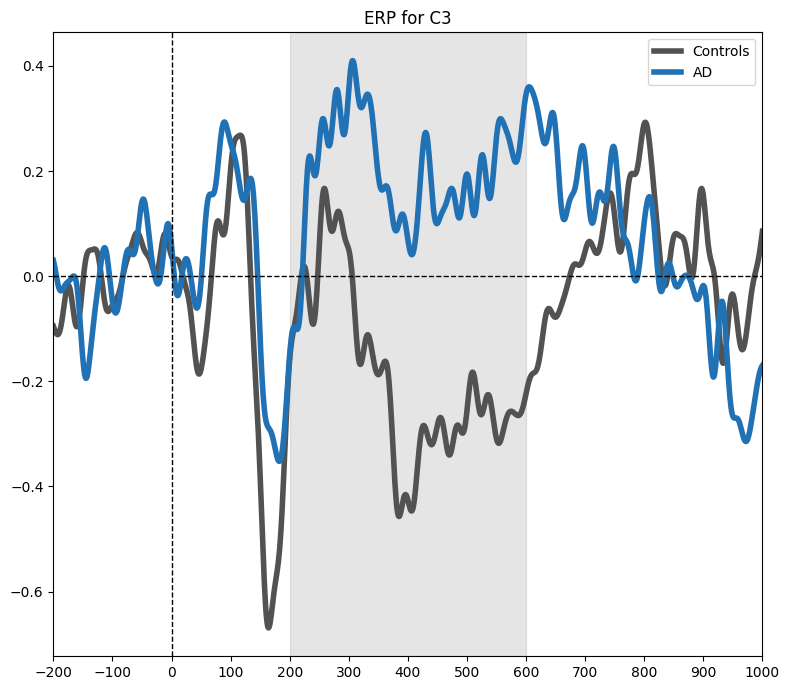

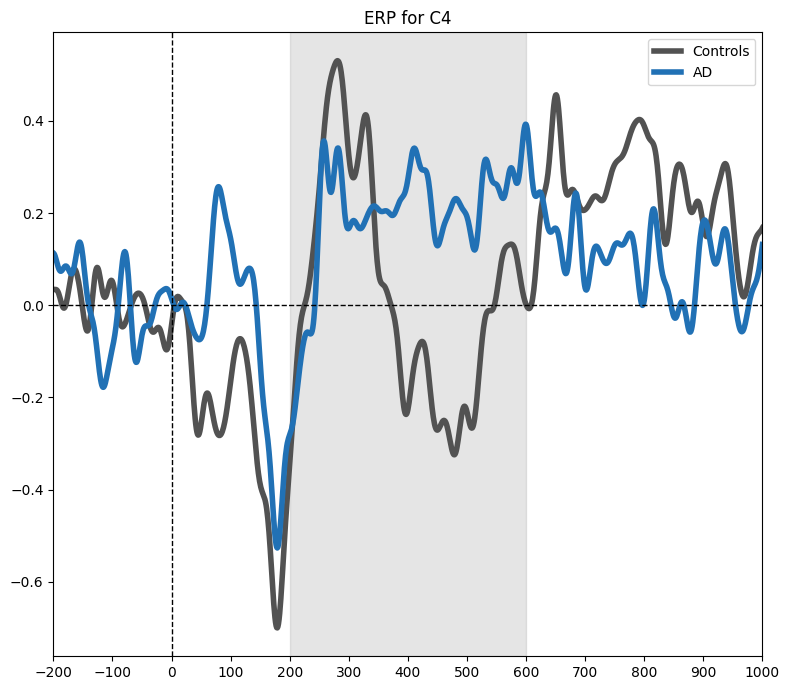

In [147]:
ch_erp = np.mean([erps[p] for p in participants], axis=0) 
con_ch = np.mean([erps[p] for p in con], axis=0)
AD_ch = np.mean([erps[p] for p in AD], axis=0)

n_chans = ch_erp.shape[0]

for ch in range(2):
    plt.figure(figsize=(8, 7))
    #plt.plot(times, ch_erp[ch], label='All', color='black', linewidth=2)
    plt.plot(times, con_ch[ch], label='Controls', color=colour_con[0], linewidth=4)
    plt.plot(times, AD_ch[ch], label='AD', color=colour_AD[0], linewidth=4)
    plt.xlim(-200,1000)
    plt.axvspan(200, 600, color='grey', alpha=0.2)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.title(f'ERP for {ch_names[ch]}')
    plt.legend()
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200, 1001, 100))
    plt.tight_layout()

## Grand Average

In [149]:
import mne, os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

erps = {}
times = np.linspace(-200, 1000, 1201)

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    labels = data['img']
    ch_names = data['chans']
    if eeg_data.shape[0] == 0:
        continue

    erp = np.mean(eeg_data, axis=(1,2)) 

    erps[participant] = erp 

for key, data in erps.items():
    participant = key
    mean_erp = np.mean(data, axis=0)
    erps[participant] = mean_erp

In [150]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    amp_mean, lat, amp_peak = extract_p300(erps[participant], times, window=(200,600))
    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)
    
con_amp_mean = np.array(con_amp_mean)
con_lat = np.array(con_lat)
con_amp_peak = np.array(con_amp_peak)


mean_amp_mean = np.mean(con_amp_mean)
mean_lat = np.mean(con_lat)
mean_amp_peak = np.mean(con_amp_peak)


std_amp_mean = np.std(con_amp_mean)
std_lat = np.std(con_lat)
std_amp_peak = np.std(con_amp_peak)

print("Control Group P300 Analysis: Grand Average in central Channels")
print(f"Mean Amplitude: {mean_amp_mean:.4f} ± {std_amp_mean:.4f} µV")
print(f"Peak Latency: {mean_lat:.4f} ± {std_lat:.4f} ms")
print(f"Peak Amplitude: {mean_amp_peak:.4f} ± {std_amp_peak:.4f} µV")

n = len(con_lat)
mean_lat = np.mean(con_lat)
std_lat = np.std(con_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat / np.sqrt(n))

ci_lower = mean_lat - moe
ci_upper = mean_lat + moe
print()
print(f"95% CI for Peak Latency control: [{ci_lower:.4f}, {ci_upper:.4f}] ms")

Control Group P300 Analysis: Grand Average in central Channels
Mean Amplitude: -0.1216 ± 0.3856 µV
Peak Latency: 236.8000 ± 27.4547 ms
Peak Amplitude: 0.2395 ± 0.1663 µV

95% CI for Peak Latency control: [198.6868, 274.9132] ms


In [151]:
AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    amp_mean, lat, amp_peak = extract_p300(erps[participant], times, window=(200,600))
    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)
    
AD_amp_mean = np.array(AD_amp_mean)
AD_lat = np.array(AD_lat)
AD_amp_peak = np.array(AD_amp_peak)

mean_amp_mean_AD = np.mean(AD_amp_mean)
mean_lat_AD = np.mean(AD_lat)
mean_amp_peak_AD = np.mean(AD_amp_peak)

std_amp_mean_AD = np.std(AD_amp_mean)
std_lat_AD = np.std(AD_lat)
std_amp_peak_AD = np.std(AD_amp_peak)

print("AD Group P300 Analysis: grand Average in central Channels")
print(f"Mean Amplitude: {mean_amp_mean_AD:.4f} ± {std_amp_mean_AD:.4f} µV")
print(f"Peak Latency: {mean_lat_AD:.4f} ± {std_lat_AD:.4f} ms")
print(f"Peak Amplitude: {mean_amp_peak_AD:.4f} ± {std_amp_peak_AD:.4f} µV")

n = len(AD_lat)
mean_lat_AD = np.mean(AD_lat)
std_lat_AD = np.std(AD_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_AD / np.sqrt(n))

ci_lower_AD = mean_lat_AD - moe
ci_upper_AD = mean_lat_AD + moe

print()
print(f"95% CI for Peak Latency AD: [{ci_lower_AD:.4f}, {ci_upper_AD:.4f}] ms")



AD Group P300 Analysis: grand Average in central Channels
Mean Amplitude: 0.2558 ± 0.3967 µV
Peak Latency: 281.0000 ± 37.1106 ms
Peak Amplitude: 0.3929 ± 0.4772 µV

95% CI for Peak Latency AD: [229.4822, 332.5178] ms


In [152]:
print("Individual con P300 Latencies - grand avg")
print(np.array(con_lat))
print("Individual AD P300 Latencies - grand avg")
print(np.array(AD_lat))

Individual con P300 Latencies - grand avg
[268. 215. 225. 205. 271.]
Individual AD P300 Latencies - grand avg
[285. 258. 226. 335. 301.]


In [153]:
mwu_p300ampmean = mwu_with_r(con_amp_mean, AD_amp_mean, name="P300 Mean Amplitude")
mwu_p300lat = mwu_with_r(con_lat, AD_lat, name="P300 Latency")
mwu_p300peak = mwu_with_r(con_amp_peak, AD_amp_peak, name="P300 Local Peak")

P300 Mean Amplitude:
 r=-0.3633, U=7.0, p=0.3095
P300 Latency:
 r=-0.5615, U=4.0, p=0.0952
P300 Local Peak:
 r=-0.0991, U=11.0, p=0.8413


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\1464227381.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


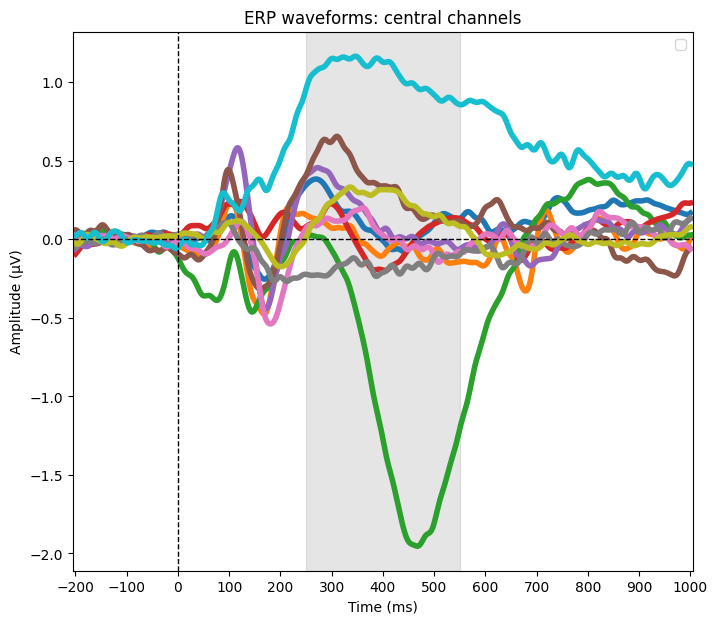

In [154]:
con_erp, AD_erp = [], []

for participant in con:
    con_erp.append(erps[participant])

for participant in AD:
    AD_erp.append(erps[participant])

con_erp = np.array(con_erp) #still maintaining participant structure
AD_erp = np.array(AD_erp)

con_mean = np.mean(con_erp, axis=(0,1)) #mean across participants and images
AD_mean = np.mean(AD_erp, axis=(0,1)) 

plt.figure(figsize=(8, 7))
plt.plot(times, con_erp.T, alpha=1, linewidth=4)
plt.plot(times, AD_erp.T, alpha=1, linewidth=4)
plt.axvspan(250, 550, color='grey', alpha=0.2)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xticks(np.arange(-200, 1001, 100))
plt.xlim(-205, 1005)
plt.title("ERP waveforms: central channels")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.show()

## Cats

In [103]:
categories = {
    "Faces": range(1, 17),       
    "Animals": range(17, 33),    
    "Places": range(33, 49),     
    "Objects": range(49, 65)   
}
categories_list = ["Faces", "Animals", "Places", "Objects"]

erps = {}

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    n_imgs = eeg_data.shape[0]
    labels = data['img']
    ch_names = data['chans']

    for category, indices in categories.items():
        n_imgs = len(indices)
        img_mask = np.isin(labels, indices)
        eeg_cat = eeg_data[img_mask]
        #print(eeg_cat.shape)
        erp = np.mean(eeg_cat, axis=(1,2))
        #print(erp.shape)
        erps[(participant, category)] = erp


In [104]:
cat_erps = {}

for key, data in erps.items():
    participant, category = key
    mean_erp = np.mean(data, axis=0)
    cat_erps[(participant, category)] = mean_erp # dictionary with keys for p and cats, then array with 1D already averaged across images

cat_con, cat_AD = {}, {}

for p in con: 
    cat_con[p] = {}
    for cat in categories_list:
        cat_con[p][cat] = cat_erps[(p, cat)]

for p in AD:
    cat_AD[p] = {}
    for cat in categories_list:
        cat_AD[p][cat] = cat_erps[(p, cat)]
    

Extract P300 information (chance cat accordingly)

In [105]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    cat_erp = cat_con[participant]["Faces"]
    amp_mean, lat, amp_peak = extract_p300(cat_erp, times, window=(250,450))

    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)

AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    cat_erp = cat_AD[participant]['Faces']
    amp_mean, lat, amp_peak = extract_p300(cat_erp, times, window=(250,450))

    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)

In [ ]:
print("Control Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(con_amp_mean):.4f} ± {np.std(con_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(con_lat):.4f} ± {np.std(con_lat):.4f} ms")
print(f"  Peak Amplitude : {np.mean(con_amp_peak):.4f} ± {np.std(con_amp_peak):.4f} µV")
print()

print("\n" + "-"*40 + "\n")

print("AD Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(AD_amp_mean):.4f} ± {np.std(AD_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(AD_lat):.4f} ± {np.std(AD_lat):.4f} ms")
print(f"  Peak Amplitude : {np.mean(AD_amp_peak):.4f} ± {np.std(AD_amp_peak):.4f} µV")
print()




Control Group P300 Analysis:
  Mean Amplitude : -0.0732 ± 0.3899 µV
  Peak Latency   : 265.2000 ± 11.1786 ms
  Peak Amplitude : 0.2270 ± 0.2033 µV

Individual Control Group P300 Latencies:
[270. 257. 255. 259. 285.]
Individual Control Group Peak Amplitudes:
[0.42334482 0.07309706 0.02320187 0.09552073 0.51962005]

----------------------------------------

AD Group P300 Analysis:
  Mean Amplitude : 0.2620 ± 0.2462 µV
  Peak Latency   : 275.4000 ± 8.4048 ms
  Peak Amplitude : 0.3410 ± 0.3281 µV

Individual AD Group P300 Latencies:
[282. 286. 269. 263. 277.]
Individual AD Group Peak Amplitudes:
[ 0.72452153  0.0813377  -0.05493288  0.22214219  0.73178888]

----------------------------------------



In [108]:
print("Individual Control Group P300 Latencies:")
print(np.array(con_lat))
print("Individual Control Group Peak Amplitudes:")
print(np.array(con_amp_peak))
print("\n" + "-"*40 + "\n")
print("Individual AD Group P300 Latencies:")
print(np.array(AD_lat))
print("Individual AD Group Peak Amplitudes:")
print(np.array(AD_amp_peak))
print("\n" + "-"*40 + "\n")

Individual Control Group P300 Latencies:
[270. 257. 255. 259. 285.]
Individual Control Group Peak Amplitudes:
[0.42334482 0.07309706 0.02320187 0.09552073 0.51962005]

----------------------------------------

Individual AD Group P300 Latencies:
[282. 286. 269. 263. 277.]
Individual AD Group Peak Amplitudes:
[ 0.72452153  0.0813377  -0.05493288  0.22214219  0.73178888]

----------------------------------------



In [107]:
mwu_n170ampmean_cat = mwu_with_r(con_amp_mean, AD_amp_mean, name="Cat P300 Mean Amplitude")
mwu_n170lat_cat = mwu_with_r(con_lat, AD_lat, name="Cat P300 Peak Latency")
mwu_n170peak_cat = mwu_with_r(con_amp_peak, AD_amp_peak, name="Cat P300 Local Peak Amplitude")

Cat P300 Mean Amplitude:
 r=-0.3633, U=7.0, p=0.3095
Cat P300 Peak Latency:
 r=-0.4294, U=6.0, p=0.2222
Cat P300 Local Peak Amplitude:
 r=-0.1651, U=10.0, p=0.6905


Work out confidence intervals (change metric accordinly)

In [ ]:
import numpy as np
from scipy import stats
import numpy as np
from scipy import stats

n = len(con_lat)
mean_lat = np.mean(con_lat)
std_lat = np.std(con_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat / np.sqrt(n))

ci_lower = mean_lat - moe
ci_upper = mean_lat + moe

print("con Group P300 Analysis: Grand Average in Parietal Channels")
#print(f"Mean Amplitude: {mean_amp_mean_AD:.4f} ± {std_amp_mean_AD:.4f} µV")
print(f"Peak Latency: {mean_lat:.4f} ± {std_lat:.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower:.4f}, {ci_upper:.4f}] ms")
#print(f"Peak Amplitude: {mean_amp_peak_AD:.4f} ± {std_amp_peak_AD:.4f} µV")

n = len(AD_lat)
mean_lat_AD = np.mean(AD_lat)
std_lat_AD = np.std(AD_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_AD / np.sqrt(n))

ci_lower_AD = mean_lat_AD - moe
ci_upper_AD = mean_lat_AD + moe

print("AD Group P300 Analysis: Grand Average in Parietal Channels")
#print(f"Mean Amplitude: {mean_amp_mean_AD:.4f} ± {std_amp_mean_AD:.4f} µV")
print(f"Peak Latency: {mean_lat_AD:.4f} ± {std_lat_AD:.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower:.4f}, {ci_upper:.4f}] ms")
#print(f"Peak Amplitude: {mean_amp_peak_AD:.4f} ± {std_amp_peak_AD:.4f} µV")


Visualisation plots

In [ ]:
plt.figure(figsize=(8, 7))
for participant in con:
    plt.plot(times, cat_con[participant]['Faces'], label=participant, alpha=0.5)
for participant in AD:
    plt.plot(times, cat_AD[participant]['Faces'], label=participant, alpha=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvspan(250, 450, color='grey', alpha=0.2)
plt.legend()
plt.xlim(-200, 1000)
plt.show()

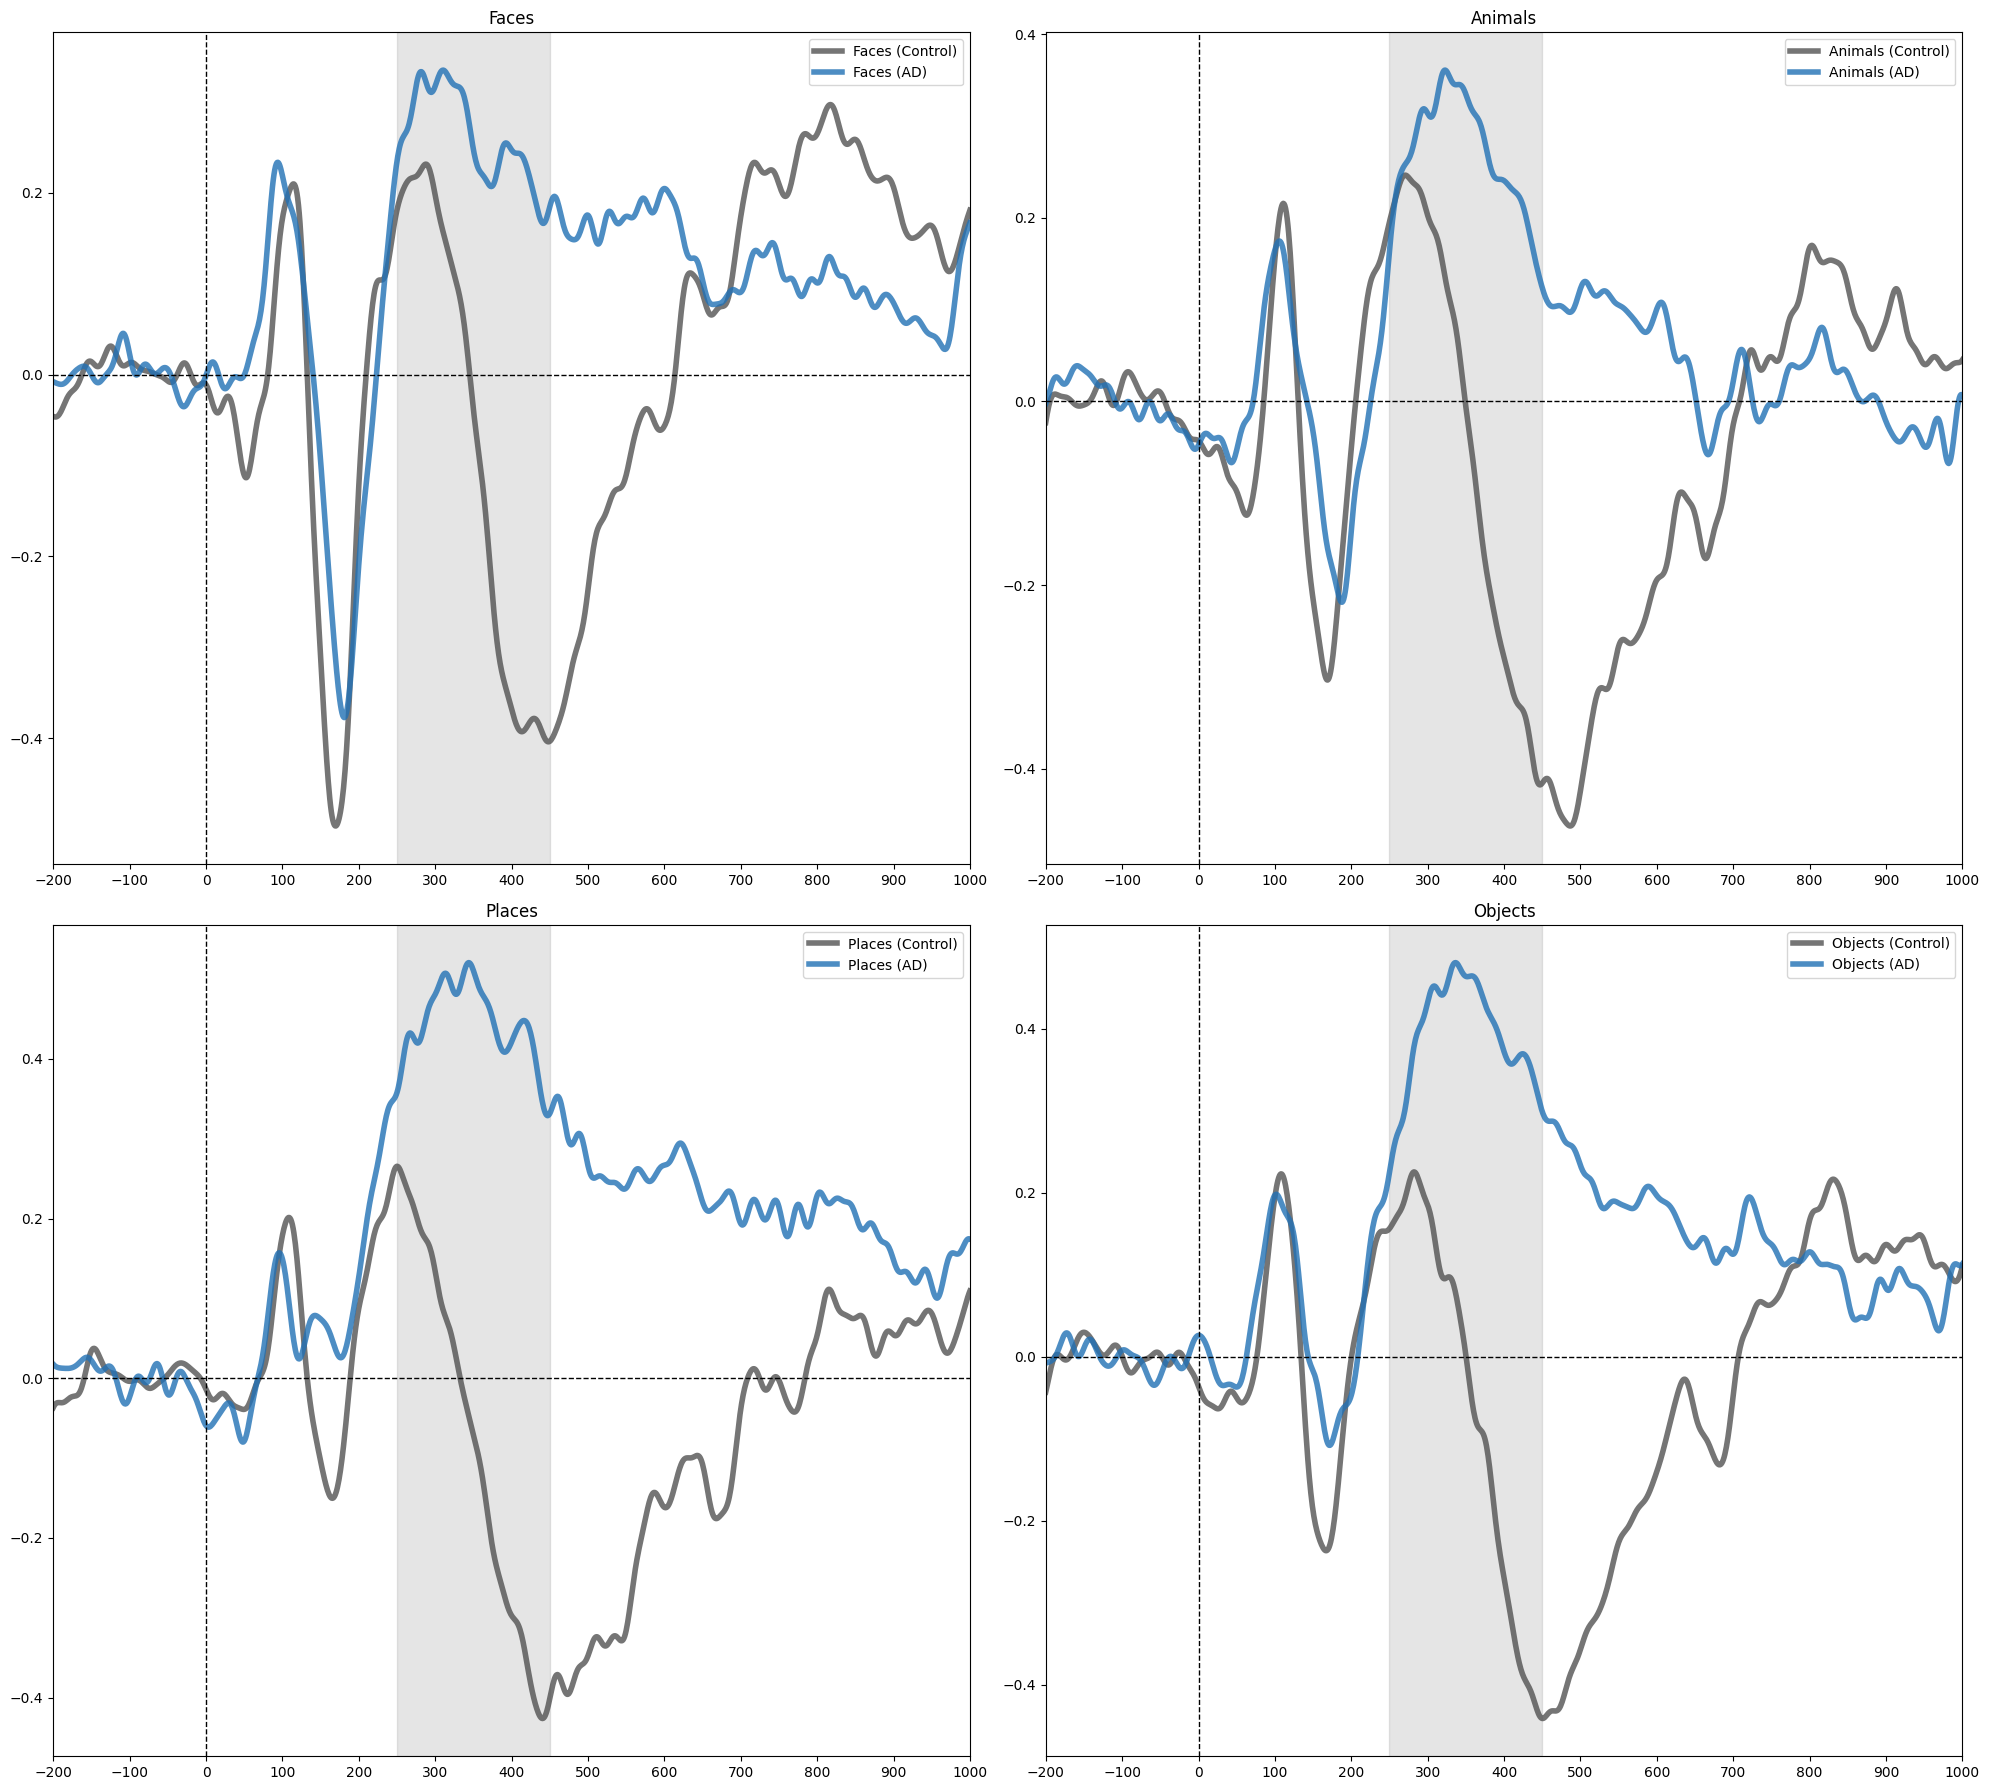

In [110]:
plt.figure(figsize=(20, 18))
for i, category in enumerate(categories_list, 1):
    con_mean = np.mean([cat_con[p][category] for p in con], axis=0)
    AD_mean = np.mean([cat_AD[p][category] for p in AD], axis=0)
    plt.subplot(2, 2, i)
    plt.plot(times, con_mean, label=f'{category} (Control)', alpha=0.8, color=colour_con[0], linewidth=4)
    plt.plot(times, AD_mean, label=f'{category} (AD)', alpha=0.8, color=colour_AD[0], linewidth=4)
    plt.axvspan(250, 450, color='grey', alpha=0.2)
    plt.title(category)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.legend()
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200, 1001, 100))
    plt.tight_layout()

plt.show()

## Sup

In [111]:
sups = {
    "Animate": range(1, 33),       
    "Inanimate": range(33, 65),    
}
sups_list = ["Animate", "Inanimate"]

erps = {}

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    n_imgs = eeg_data.shape[0]
    labels = data['img']
    ch_names = data['chans']

    for category, indices in sups.items():
        n_imgs = len(indices)
        img_mask = np.isin(labels, indices)
        eeg_cat = eeg_data[img_mask]
        #print(eeg_cat.shape)
        erp = np.mean(eeg_cat, axis=(1,2))
        #print(erp.shape)
        erps[(participant, category)] = erp


In [112]:
sup_erps = {}

for key, data in erps.items():
    participant, category = key
    mean_erp = np.mean(data, axis=0)
    cat_erps[(participant, category)] = mean_erp # dictionary with keys for p and cats, then array with 1D already averaged across images

sup_con, sup_AD = {}, {}

for p in con: 
    sup_con[p] = {}
    for cat in sups_list:
        sup_con[p][cat] = cat_erps[(p, cat)]

for p in AD:
    sup_AD[p] = {}
    for cat in sups_list:
        sup_AD[p][cat] = cat_erps[(p, cat)]
    

Extract P300 information (change sup accordingly)

In [113]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    sup_erp = sup_con[participant]["Animate"]
    amp_mean, lat, amp_peak = extract_p300(sup_erp, times, window=(250,450))

    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)

AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    sup_erp = sup_AD[participant]['Animate']
    amp_mean, lat, amp_peak = extract_p300(sup_erp, times, window=(250, 450))

    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)

print("Individual Control Group P300 Latencies:")
print(np.array(con_lat))
print("Individual Control Group Peak Amplitudes:")
print(np.array(con_amp_peak))
print("\n" + "-"*40 + "\n")
print("Individual AD Group P300 Latencies:")
print(np.array(AD_lat))
print("Individual AD Group Peak Amplitudes:")
print(np.array(AD_amp_peak))
print("\n" + "-"*40 + "\n")

Individual Control Group P300 Latencies:
[271. 262. 255. 260. 273.]
Individual Control Group Peak Amplitudes:
[0.42471426 0.12236085 0.07300998 0.0463216  0.51896173]

----------------------------------------

Individual AD Group P300 Latencies:
[284. 258. 255. 336. 276.]
Individual AD Group Peak Amplitudes:
[ 0.64527707  0.09172856 -0.14520941  0.2953852   0.77855948]

----------------------------------------



Confidence intervals analysis (change metric accordingly)

In [114]:
import numpy as np
from scipy import stats
n = len(con_lat)
mean_lat_con = np.mean(con_lat)
std_lat_con = np.std(con_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_con / np.sqrt(n))

ci_lower_con = mean_lat_con - moe
ci_upper_con = mean_lat_con + moe


print("Control Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(con_amp_mean):.4f} ± {np.std(con_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(con_lat):.4f} ± {np.std(con_lat):.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower_con:.4f}, {ci_upper_con:.4f}] ms")
print()
print(f"  Peak Amplitude : {np.mean(con_amp_peak):.4f} ± {np.std(con_amp_peak):.4f} µV")
print()



n = len(AD_lat)
mean_lat_AD = np.mean(AD_lat)
std_lat_AD = np.std(AD_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_AD / np.sqrt(n))

ci_lower_AD = mean_lat_AD - moe
ci_upper_AD = mean_lat_AD + moe


print("AD Group P300 Analysis:")
#print(f"  Mean Amplitude : {np.mean(AD_amp_mean):.4f} ± {np.std(AD_amp_mean):.4f} µV")
print()
print(f"  Peak Latency   : {np.mean(AD_lat):.4f} ± {np.std(AD_lat):.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower_AD:.4f}, {ci_upper_AD:.4f}] ms")
print()
#print(f"  Peak Amplitude : {np.mean(AD_amp_peak):.4f} ± {np.std(AD_amp_peak):.4f} µV")
print()
print()


Control Group P300 Analysis:
  Mean Amplitude : -0.0558 ± 0.3320 µV
  Peak Latency   : 264.2000 ± 6.7941 ms
95% CI for Peak Latency: [254.7683, 273.6317] ms

  Peak Amplitude : 0.2371 ± 0.1955 µV

AD Group P300 Analysis:

  Peak Latency   : 281.8000 ± 29.1918 ms
95% CI for Peak Latency: [241.2753, 322.3247] ms





In [115]:
mwu_n170ampmean_sup = mwu_with_r(con_amp_mean, AD_amp_mean, name="Sup P300 Mean Amplitude")
mwu_n170lat_sup = mwu_with_r(con_lat, AD_lat, name="Sup P300 Peak Latency")
mwu_n170peak_sup = mwu_with_r(con_amp_peak, AD_amp_peak, name="Sup P300 Local Peak Amplitude")

Sup P300 Mean Amplitude:
 r=-0.3633, U=7.0, p=0.3095
Sup P300 Peak Latency:
 r=-0.2642, U=8.5, p=0.4633
Sup P300 Local Peak Amplitude:
 r=-0.1651, U=10.0, p=0.6905


Visualisation plots

In [ ]:
plt.figure(figsize=(8, 7))
for participant in con:
    plt.plot(times, sup_con[participant]['Animate'], label=participant, alpha=0.5)
for participant in AD:
    plt.plot(times, sup_AD[participant]['Animate'], label=participant, alpha=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvspan(250, 450, color='grey', alpha=0.2)
plt.legend()
plt.xlim(-200, 1000)
plt.show()

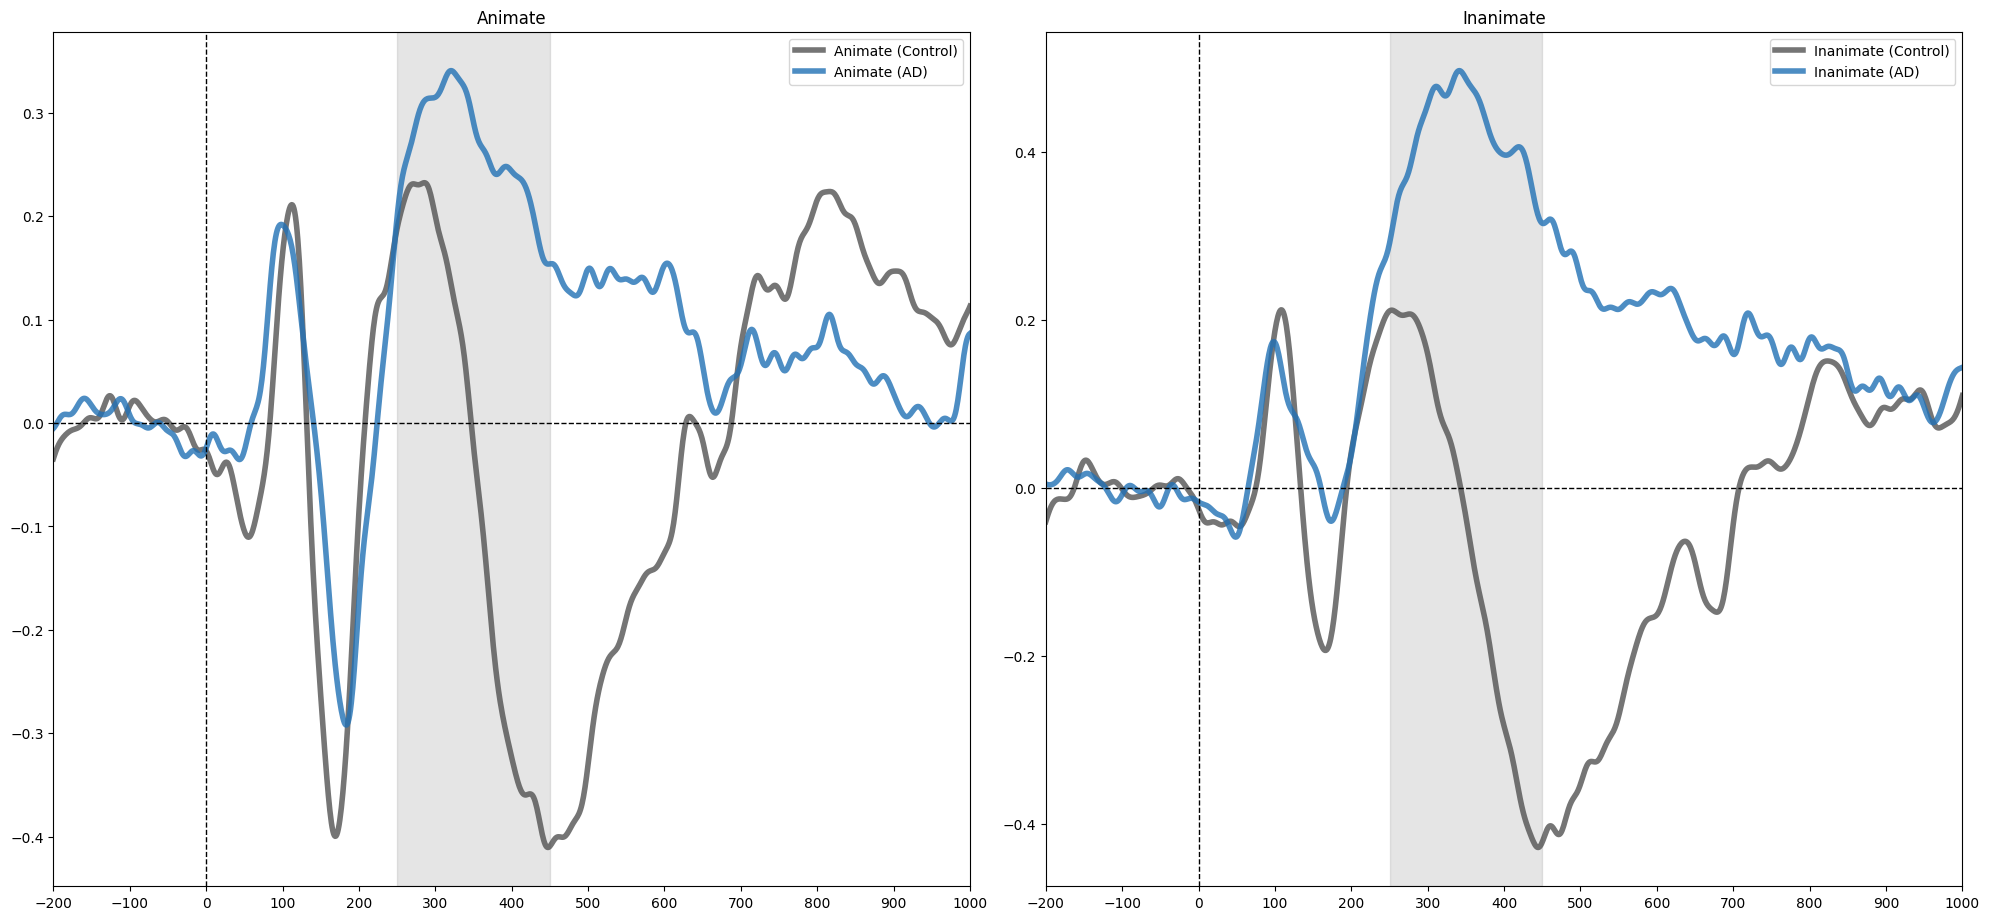

In [119]:
plt.figure(figsize=(20, 18))
for i, category in enumerate(sups_list, 1):
    con_mean = np.mean([sup_con[p][category] for p in con], axis=0)
    AD_mean = np.mean([sup_AD[p][category] for p in AD], axis=0)
    plt.subplot(2, 2, i)
    plt.plot(times, con_mean, label=f'{category} (Control)', alpha=0.8, color=colour_con[0], linewidth=4)
    plt.plot(times, AD_mean, label=f'{category} (AD)', alpha=0.8, color=colour_AD[0], linewidth=4)
    plt.axvspan(250, 450, color='grey', alpha=0.2)
    plt.title(category)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.legend()
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200, 1001, 100))
    plt.tight_layout()

plt.show()

# Parietal channels

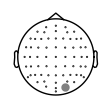

(<matplotlib.image.AxesImage at 0x1d26b8c4e30>, None)

In [170]:
import numpy as np
import mne

# Load standard montage and create dummy info
montage = mne.channels.make_standard_montage('biosemi64')
ch_names = montage.ch_names
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage)

# Create dummy data: all zeros (no actual data needed)
data = np.zeros(len(ch_names))

sel_ch = ['O2']

# Create mask
mask = np.array([[ch in sel_ch for ch in ch_names]]).T

# Plot topomap highlighting channels
mne.viz.plot_topomap(
    data,
    pos=info,
    names=None,
    mask=mask,
    mask_params=dict(
        marker='o',
        markerfacecolor='gray',
        markersize=3,
        markeredgewidth=3,
        markeredgecolor='gray',
        
    ),
    contours=0,
    cmap='Greys',
)


In [160]:
def get_data(subject, dirs, n_runs=8): 
    eeg_path = os.path.join(dirs["eeg"], subject)
    behav_path = os.path.join(dirs["behav"], subject)

    eeg = []
    labels = []
    image_nr_list = []
    rt_list = []
    responded_list= []
    
    for run in range(n_runs):
        mat_file = 'run{:02d}_eeg.mat'.format(run+1)
        mat_path = os.path.join(behav_path, mat_file)
        mat_data = scipy.io.loadmat(mat_path, simplify_cells=True)

        trial_df = pd.DataFrame(mat_data['results']['trial'])
        image_nr = trial_df['image_nr'].values
        rt = trial_df['RT'].values
        responded = trial_df['responded'].values

        eeg_filename = '{}_b{}.vhdr'.format(subject.lower(), run+1)
        eeg_file = os.path.join(eeg_path, eeg_filename)

        # Load EEG
        raw = mne.io.read_raw_brainvision(eeg_file, preload=True)
        raw.filter(l_freq=0.01, h_freq=40) #changed from 0.1 to 0.01
        #raw.resample(sfreq = 50)
        events, event_id = mne.events_from_annotations(raw)
        raw.pick_types(eeg=True)

        img_events = events[np.isin(events[:, 2],[4,8])]
        exp_mask = image_nr < 65
        
        try:
            events_oi = img_events[exp_mask]
        except IndexError:
            print('Error: no events found')
            continue 

        images_oi = image_nr[exp_mask]

        epochs = mne.Epochs(
            raw, events_oi, tmin=-0.2, tmax=1,
            baseline=(None, 0), preload=True, reject_by_annotation=False, reject=None, picks=par_ch  # Change accordingly for other ERPs
        )

        eeg_ = epochs.get_data()

        if eeg_.shape[0] != len(events_oi):
            print('Error: epochs were dropped. Handle it')
            break

        eeg.append(eeg_)
        labels.append(images_oi)

        rt_list.append(rt)
        responded_list.append(responded)
        image_nr_list.append(image_nr)


        channels = channels if 'channels' in locals() else epochs.ch_names
        times = times if 'times' in locals() else epochs.times

    eeg = np.concatenate(eeg, axis=0)
    labels = np.concatenate(labels, axis =0)

    n_trials, n_chans, n_times = eeg.shape

    image_nr = np.concatenate(image_nr_list, axis = 0)
    rt = np.concatenate(rt_list, axis = 0)
    responded = np.concatenate(responded_list, axis = 0)

    n_bl = np.sum(times <=0)
    bl_mean = np.array([[np.mean(eeg[x,y,:n_bl]) for y in range(n_chans)] for x in range(n_trials)])
    bl_std = np.array([[np.std(eeg[x,y,:n_bl]) for y in range(n_chans)] for x in range(n_trials)])
    eeg = np.array([[(eeg[x,y,:] - bl_mean[x,y]) / bl_std[x,y] for y in range(n_chans)] for x in range(n_trials)])

    labels_unique, labels_count = np.unique(labels, return_counts=True)
    n_imgs = len(labels_unique)
    n_reps = max(labels_count)

    _, n_chans, n_times = eeg.shape

    eeg_data = np.full((n_imgs, n_reps, n_chans, n_times), np.nan)
    for i,img in enumerate(labels_unique):
        im_mask = labels == img
        eeg_data[i] = eeg[im_mask]
    
    out_dict = {
                'eeg': eeg_data,
                'img': labels_unique,
                'chans': channels,
                'times': times,
                'subject': subject
    }

    behav_data = {'subject': subject,
                  'rt': rt, 
                  'responded': responded, 
                  'labels': image_nr}
    
    return(out_dict, behav_data)

In [161]:
out_dict = []
behav_data = []

for participant in participants:
    data, behav = get_data(participant, dirs)
    out_dict.append(data)
    behav_data.append(behav)


Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b1.vhdr...
Setting channel info structure...
Reading 0 ... 383359  =      0.000 ...   383.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b2.vhdr...
Setting channel info structure...
Reading 0 ... 380519  =      0.000 ...   380.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b3.vhdr...
Setting channel info structure...
Reading 0 ... 382059  =      0.000 ...   382.059 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    7.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379139  =      0.000 ...   379.139 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b5.vhdr...
Setting channel info structure...
Reading 0 ... 385359  =      0.000 ...   385.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b6.vhdr...
Setting channel info structure...
Reading 0 ... 384459  =      0.000 ...   384.459 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b7.vhdr...
Setting channel info structure...
Reading 0 ... 389459  =      0.000 ...   389.459 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K01\k01_b8.vhdr...
Setting channel info structure...
Reading 0 ... 390079  =      0.000 ...   390.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b1.vhdr...
Setting channel info structure...
Reading 0 ... 474899  =      0.000 ...   474.899 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b2.vhdr...
Setting channel info structure...
Reading 0 ... 365079  =      0.000 ...   365.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b3.vhdr...
Setting channel info structure...
Reading 0 ... 375619  =      0.000 ...   375.619 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b4.vhdr...
Setting channel info structure...
Reading 0 ... 371239  =      0.000 ...   371.239 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b5.vhdr...
Setting channel info structure...
Reading 0 ... 375519  =      0.000 ...   375.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b6.vhdr...
Setting channel info structure...
Reading 0 ... 382699  =      0.000 ...   382.699 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b7.vhdr...
Setting channel info structure...
Reading 0 ... 374099  =      0.000 ...   374.099 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K02\k02_b8.vhdr...
Setting channel info structure...
Reading 0 ... 372199  =      0.000 ...   372.199 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b1.vhdr...
Setting channel info structure...
Reading 0 ... 443919  =      0.000 ...   443.919 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b2.vhdr...
Setting channel info structure...
Reading 0 ... 376659  =      0.000 ...   376.659 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b3.vhdr...
Setting channel info structure...
Reading 0 ... 383679  =      0.000 ...   383.679 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b4.vhdr...
Setting channel info structure...
Reading 0 ... 377499  =      0.000 ...   377.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b5.vhdr...
Setting channel info structure...
Reading 0 ... 380359  =      0.000 ...   380.359 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b6.vhdr...
Setting channel info structure...
Reading 0 ... 380479  =      0.000 ...   380.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b7.vhdr...
Setting channel info structure...
Reading 0 ... 379299  =      0.000 ...   379.299 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K03\k03_b8.vhdr...
Setting channel info structure...
Reading 0 ... 427159  =      0.000 ...   427.159 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b1.vhdr...
Setting channel info structure...
Reading 0 ... 415479  =      0.000 ...   415.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b2.vhdr...
Setting channel info structure...
Reading 0 ... 377059  =      0.000 ...   377.059 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b3.vhdr...
Setting channel info structure...
Reading 0 ... 378599  =      0.000 ...   378.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379779  =      0.000 ...   379.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b5.vhdr...
Setting channel info structure...
Reading 0 ... 386959  =      0.000 ...   386.959 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b6.vhdr...
Setting channel info structure...
Reading 0 ... 379399  =      0.000 ...   379.399 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b7.vhdr...
Setting channel info structure...
Reading 0 ... 382079  =      0.000 ...   382.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K04\k04_b8.vhdr...
Setting channel info structure...
Reading 0 ... 382279  =      0.000 ...   382.279 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b1.vhdr...
Setting channel info structure...
Reading 0 ... 382339  =      0.000 ...   382.339 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b2.vhdr...
Setting channel info structure...
Reading 0 ... 390399  =      0.000 ...   390.399 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b3.vhdr...
Setting channel info structure...
Reading 0 ... 379719  =      0.000 ...   379.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b4.vhdr...
Setting channel info structure...
Reading 0 ... 381719  =      0.000 ...   381.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b5.vhdr...
Setting channel info structure...
Reading 0 ... 382659  =      0.000 ...   382.659 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b6.vhdr...
Setting channel info structure...
Reading 0 ... 379599  =      0.000 ...   379.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b7.vhdr...
Setting channel info structure...
Reading 0 ... 377039  =      0.000 ...   377.039 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K05\k05_b8.vhdr...
Setting channel info structure...
Reading 0 ... 377419  =      0.000 ...   377.419 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  1'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b1.vhdr...
Setting channel info structure...
Reading 0 ... 406119  =      0.000 ...   406.119 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b2.vhdr...
Setting channel info structure...
Reading 0 ... 386859  =      0.000 ...   386.859 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b3.vhdr...
Setting channel info structure...
Reading 0 ... 377539  =      0.000 ...   377.539 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b4.vhdr...
Setting channel info structure...
Reading 0 ... 397079  =      0.000 ...   397.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b5.vhdr...
Setting channel info structure...
Reading 0 ... 388759  =      0.000 ...   388.759 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b6.vhdr...
Setting channel info structure...
Reading 0 ... 380639  =      0.000 ...   380.639 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b7.vhdr...
Setting channel info structure...
Reading 0 ... 383179  =      0.000 ...   383.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K06\k06_b8.vhdr...
Setting channel info structure...
Reading 0 ... 383179  =      0.000 ...   383.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b1.vhdr...
Setting channel info structure...
Reading 0 ... 374879  =      0.000 ...   374.879 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b2.vhdr...
Setting channel info structure...
Reading 0 ... 383679  =      0.000 ...   383.679 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b3.vhdr...
Setting channel info structure...
Reading 0 ... 357379  =      0.000 ...   357.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b4.vhdr...
Setting channel info structure...
Reading 0 ... 385139  =      0.000 ...   385.139 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b5.vhdr...
Setting channel info structure...
Reading 0 ... 380779  =      0.000 ...   380.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b6.vhdr...
Setting channel info structure...
Reading 0 ... 378239  =      0.000 ...   378.239 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b7.vhdr...
Setting channel info structure...
Reading 0 ... 379719  =      0.000 ...   379.719 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K07\k07_b8.vhdr...
Setting channel info structure...
Reading 0 ... 215759  =      0.000 ...   215.759 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)
C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:26: RuntimeWarning: filter_length (330001) is longer than the signal (215760), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=0.01, h_freq=40) #changed from 0.1 to 0.01
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b1.vhdr...
Setting channel info structure...
Reading 0 ... 391179  =      0.000 ...   391.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b2.vhdr...
Setting channel info structure...
Reading 0 ... 447079  =      0.000 ...   447.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.3s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b3.vhdr...
Setting channel info structure...
Reading 0 ... 383499  =      0.000 ...   383.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b4.vhdr...
Setting channel info structure...
Reading 0 ... 375859  =      0.000 ...   375.859 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.1s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b5.vhdr...
Setting channel info structure...
Reading 0 ... 382979  =      0.000 ...   382.979 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b6.vhdr...
Setting channel info structure...
Reading 0 ... 391619  =      0.000 ...   391.619 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b7.vhdr...
Setting channel info structure...
Reading 0 ... 363299  =      0.000 ...   363.299 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K08\k08_b8.vhdr...
Setting channel info structure...
Reading 0 ... 375479  =      0.000 ...   375.479 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b1.vhdr...
Setting channel info structure...
Reading 0 ... 403519  =      0.000 ...   403.519 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b2.vhdr...
Setting channel info structure...
Reading 0 ... 380499  =      0.000 ...   380.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b3.vhdr...
Setting channel info structure...
Reading 0 ... 387499  =      0.000 ...   387.499 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b4.vhdr...
Setting channel info structure...
Reading 0 ... 379939  =      0.000 ...   379.939 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b5.vhdr...
Setting channel info structure...
Reading 0 ... 381079  =      0.000 ...   381.079 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b6.vhdr...
Setting channel info structure...
Reading 0 ... 374179  =      0.000 ...   374.179 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b7.vhdr...
Setting channel info structure...
Reading 0 ... 378639  =      0.000 ...   378.639 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K09\k09_b8.vhdr...
Setting channel info structure...
Reading 0 ... 373779  =      0.000 ...   373.779 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b1.vhdr...
Setting channel info structure...
Reading 0 ... 386599  =      0.000 ...   386.599 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b2.vhdr...
Setting channel info structure...
Reading 0 ... 379199  =      0.000 ...   379.199 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b3.vhdr...
Setting channel info structure...
Reading 0 ... 364699  =      0.000 ...   364.699 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b4.vhdr...
Setting channel info structure...
Reading 0 ... 372379  =      0.000 ...   372.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Error: no events found
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b5.vhdr...
Setting channel info structure...
Reading 0 ... 376379  =      0.000 ...   376.379 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
0 bad epochs dropped
Extracting parameters from C:\Users\victo\Desktop\MRes\25MResButler\250129pilot\EEG_data\K10\k10_b6.vhdr...
Setting channel info structure...
Reading 0 ... 373799  =      0.000 ...   373.799 secs...


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\4100729387.py:25: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Response/R  8'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  8')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
256 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1201 original time points ...
1 bad epochs dropped
Error: epochs were dropped. Handle it


## Comparing par_ch

In [178]:
import mne, os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

erps = {}
times = np.linspace(-200, 1000, 1201)

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    labels = data['img']
    ch_names = data['chans']
    if eeg_data.shape[0] == 0:
        continue

    erp = np.mean(eeg_data, axis=(0,1)) 

    erps[participant] = erp 

ch_erp = np.mean([erps[p] for p in participants], axis=0) 
con_ch = np.mean([erps[p] for p in con], axis=0)
AD_ch = np.mean([erps[p] for p in AD], axis=0)

In [220]:
erps

{'K01': array([[-0.04833467, -0.04845817, -0.04881042, ...,  0.22879343,
          0.23065222,  0.2324293 ],
        [-0.04125172, -0.04105324, -0.04101173, ...,  0.25418563,
          0.25497812,  0.25596313],
        [-0.05494231, -0.05132282, -0.04773547, ...,  0.1923806 ,
          0.19612828,  0.20014007]], shape=(3, 1201)),
 'K02': array([[ 0.07387408,  0.07465868,  0.07558587, ..., -0.10606089,
         -0.09649196, -0.08724273],
        [ 0.08101441,  0.08362803,  0.08589137, ..., -0.08138064,
         -0.07328512, -0.06517286],
        [ 0.04525491,  0.04591716,  0.04656434, ..., -0.07049449,
         -0.05731724, -0.04436903]], shape=(3, 1201)),
 'K03': array([[-0.00401645,  0.00059388,  0.00502002, ..., -0.01781631,
         -0.01436453, -0.01055074],
        [-0.02900173, -0.0226261 , -0.01705977, ...,  0.20737809,
          0.21587111,  0.22473882],
        [-0.0425168 , -0.03661542, -0.031067  , ...,  0.14818874,
          0.15607522,  0.16385755]], shape=(3, 1201)),
 'K0

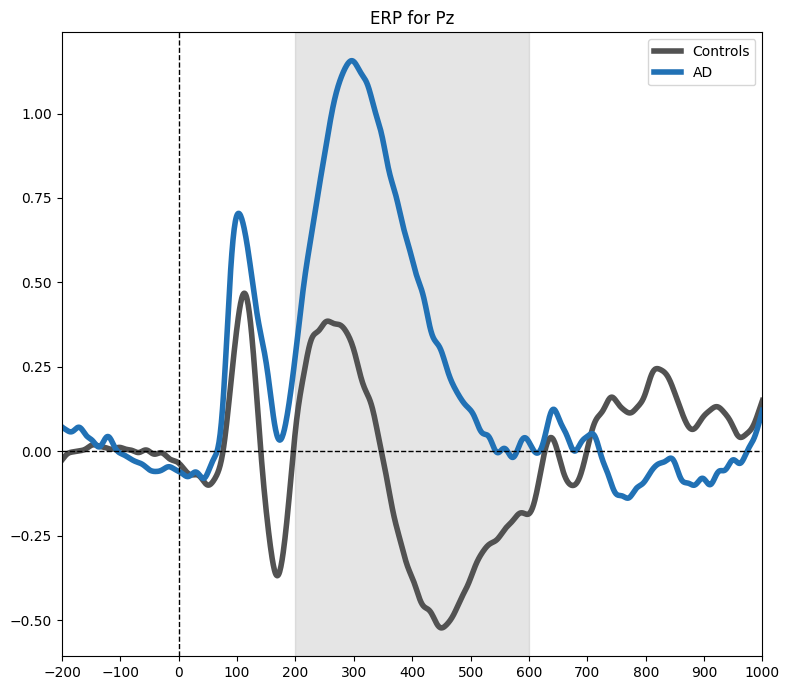

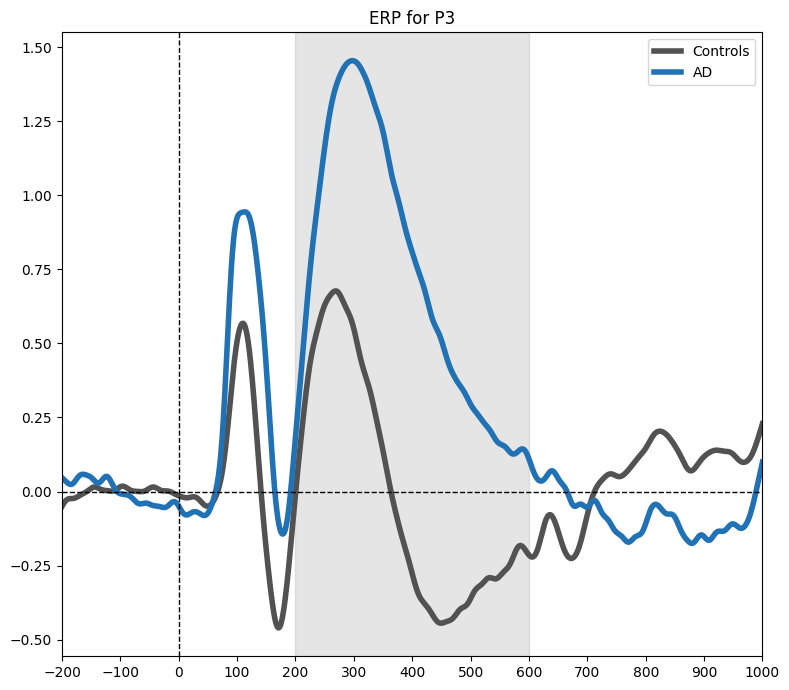

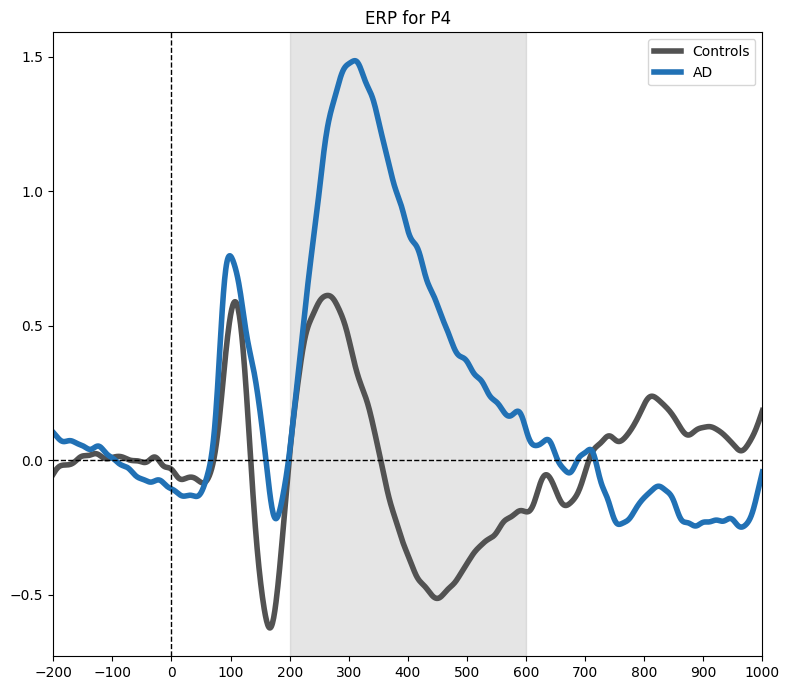

In [163]:
for ch in range(3):
    plt.figure(figsize=(8, 7))
    #plt.plot(times, ch_erp[ch], label='All', color='black', linewidth=2)
    plt.plot(times, con_ch[ch], label='Controls', color=colour_con[0], linewidth=4)
    plt.plot(times, AD_ch[ch], label='AD', color=colour_AD[0], linewidth=4)
    plt.xlim(-200,1000)
    plt.axvspan(200, 600, color='grey', alpha=0.2)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.title(f'ERP for {ch_names[ch]}')
    plt.legend()
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200, 1001, 100))
    plt.tight_layout()

Change channel accordingly

In [260]:
ch_erp = np.array([erps[p][0, :] for p in participants])  # shape: (n_participants, n_times)
con_ch = [erps[p][0, :] for p in con]
AD_ch = [erps[p][0, :] for p in AD]

In [261]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for p in range(len(con)):
    amp_mean, lat, amp_peak = extract_p300(con_ch[p], times, window=(200,600))
    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)
    
con_amp_mean = np.array(con_amp_mean)
con_lat = np.array(con_lat)
con_amp_peak = np.array(con_amp_peak)


mean_amp_mean = np.mean(con_amp_mean)
mean_lat = np.mean(con_lat)
mean_amp_peak = np.mean(con_amp_peak)


std_amp_mean = np.std(con_amp_mean)
std_lat = np.std(con_lat)
std_amp_peak = np.std(con_amp_peak)

print("Control Group P300 Analysis:")
print(f"Mean Amplitude: {mean_amp_mean:.4f} ± {std_amp_mean:.4f} µV")
print(f"Peak Latency: {mean_lat:.4f} ± {std_lat:.4f} ms")
print(f"Peak Amplitude: {mean_amp_peak:.4f} ± {std_amp_peak:.4f} µV")

Control Group P300 Analysis:
Mean Amplitude: -0.1065 ± 0.4760 µV
Peak Latency: 237.4000 ± 22.0599 ms
Peak Amplitude: 0.4415 ± 0.1833 µV


In [262]:
AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for p in range(len(AD)):
    amp_mean, lat, amp_peak = extract_p300(AD_ch[p], times, window=(200,600))
    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)
    
AD_amp_mean = np.array(AD_amp_mean)
AD_lat = np.array(AD_lat)
AD_amp_peak = np.array(AD_amp_peak)

mean_amp_mean_AD = np.mean(AD_amp_mean)
mean_lat_AD = np.mean(AD_lat)
mean_amp_peak_AD = np.mean(AD_amp_peak)


std_amp_mean_AD = np.std(AD_amp_mean)
std_lat_AD = np.std(AD_lat)
std_amp_peak_AD = np.std(AD_amp_peak)

print("AD Group P300 Analysis:")
print(f"Mean Amplitude: {mean_amp_mean_AD:.4f} ± {std_amp_mean_AD:.4f} µV")
print(f"Peak Latency: {mean_lat_AD:.4f} ± {std_lat_AD:.4f} ms")
print(f"Peak Amplitude: {mean_amp_peak_AD:.4f} ± {std_amp_peak_AD:.4f} µV")

AD Group P300 Analysis:
Mean Amplitude: 0.5174 ± 0.5869 µV
Peak Latency: 303.2000 ± 24.7338 ms
Peak Amplitude: 1.2389 ± 0.5332 µV


In [263]:
mwu_p300ampmean = mwu_with_r(con_amp_mean, AD_amp_mean, name="P300 Mean Amplitude")
mwu_p300lat = mwu_with_r(con_lat, AD_lat, name="P300 Latency")
mwu_p300peak = mwu_with_r(con_amp_peak, AD_amp_peak, name="P300 Local Peak")

P300 Mean Amplitude:
 r=-0.4294, U=6.0, p=0.2222
P300 Latency:
 r=-0.8257, U=0.0, p=0.0079
P300 Local Peak:
 r=-0.6275, U=3.0, p=0.0556


## Grand Average

In [267]:
import mne, os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

erps = {}
times = np.linspace(-200, 1000, 1201)

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    labels = data['img']
    ch_names = data['chans']
    if eeg_data.shape[0] == 0:
        continue

    erp = np.mean(eeg_data, axis=(1,2)) 

    erps[participant] = erp 

for key, data in erps.items():
    participant = key
    mean_erp = np.mean(data, axis=0)
    erps[participant] = mean_erp

In [271]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    amp_mean, lat, amp_peak = extract_p300(erps[participant], times, window=(200,600))
    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)
    
con_amp_mean = np.array(con_amp_mean)
con_lat = np.array(con_lat)
con_amp_peak = np.array(con_amp_peak)


print("Control Group P300 Analysis: Grand Average in parietal Channels")


import numpy as np
from scipy import stats

n = len(con_lat)
mean_lat = np.mean(con_lat)
std_lat = np.std(con_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat / np.sqrt(n))

ci_lower = mean_lat - moe
ci_upper = mean_lat + moe

print()
#print(f"Mean Amplitude: {mean_amp_mean_AD:.4f} ± {std_amp_mean_AD:.4f} µV")
print(f"Peak Latency: {mean_lat:.4f} ± {std_lat:.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower:.4f}, {ci_upper:.4f}] ms")
#print(f"Peak Amplitude: {mean_amp_peak_AD:.4f} ± {std_amp_peak_AD:.4f} µV")

Control Group P300 Analysis: Grand Average in parietal Channels

Peak Latency: 244.4000 ± 21.4196 ms
95% CI for Peak Latency: [217.8040, 270.9960] ms


In [272]:
AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    amp_mean, lat, amp_peak = extract_p300(erps[participant], times, window=(200,600))
    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)
    
AD_amp_mean = np.array(AD_amp_mean)
AD_lat = np.array(AD_lat)
AD_amp_peak = np.array(AD_amp_peak)

print("AD Group P300 Analysis:Grand Average in Parietal Channels")



n = len(AD_lat)
mean_lat_AD = np.mean(AD_lat)
std_lat_AD = np.std(AD_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_AD / np.sqrt(n))

ci_lower_AD = mean_lat_AD - moe
ci_upper_AD = mean_lat_AD + moe

print()

print(f"Peak Latency: {mean_lat_AD:.4f} ± {std_lat_AD:.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower_AD:.4f}, {ci_upper_AD:.4f}] ms")

AD Group P300 Analysis:Grand Average in Parietal Channels

Peak Latency: 300.6000 ± 19.9198 ms
95% CI for Peak Latency: [275.8663, 325.3337] ms


In [174]:
print("Individual con P300 Latencies - grand avg")
print(np.array(con_lat))
print("Individual AD P300 Latencies - grand avg")
print(np.array(AD_lat))

Individual con P300 Latencies - grand avg
[256. 225. 253. 219. 269.]
Individual AD P300 Latencies - grand avg
[285. 276. 324. 314. 304.]


In [175]:
mwu_p300ampmean = mwu_with_r(con_amp_mean, AD_amp_mean, name="P300 Mean Amplitude")
mwu_p300lat = mwu_with_r(con_lat, AD_lat, name="P300 Latency")
mwu_p300peak = mwu_with_r(con_amp_peak, AD_amp_peak, name="P300 Local Peak")

P300 Mean Amplitude:
 r=-0.6275, U=3.0, p=0.0556
P300 Latency:
 r=-0.8257, U=0.0, p=0.0079
P300 Local Peak:
 r=-0.6936, U=2.0, p=0.0317


C:\Users\victo\AppData\Local\Temp\ipykernel_18180\3703464850.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


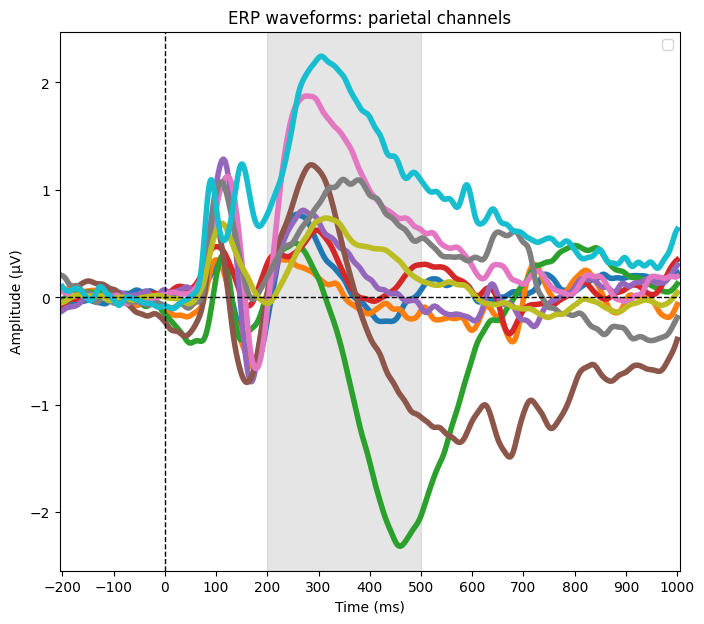

In [273]:
con_erp, AD_erp = [], []

for participant in con:
    con_erp.append(erps[participant])

for participant in AD:
    AD_erp.append(erps[participant])

con_erp = np.array(con_erp) #still maintaining participant structure
AD_erp = np.array(AD_erp)


plt.figure(figsize=(8, 7))
plt.plot(times, con_erp.T, alpha=1, linewidth=4)
plt.plot(times, AD_erp.T, alpha=1, linewidth=4)
plt.axvspan(200, 500, color='grey', alpha=0.2)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xticks(np.arange(-200, 1001, 100))
plt.xlim(-205, 1005)
plt.title("ERP waveforms: parietal channels")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.show()

C:\Users\victo\AppData\Local\Temp\ipykernel_18180\3464541019.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


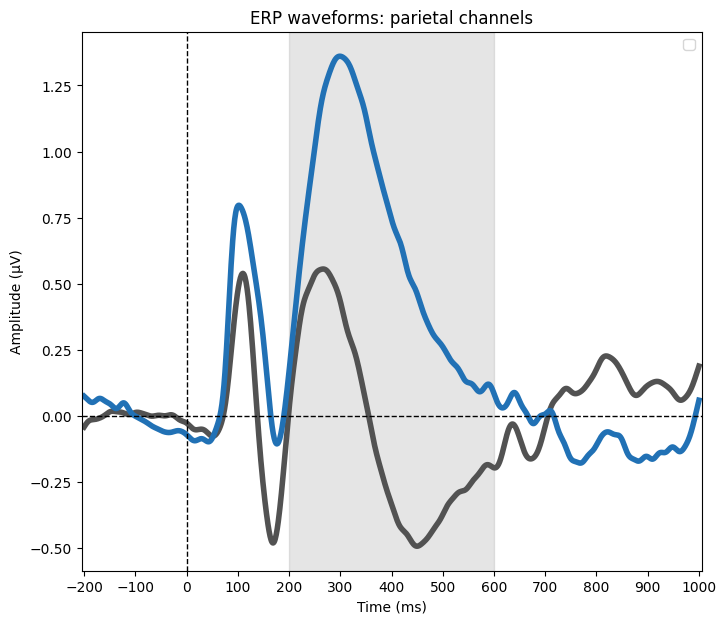

In [275]:
con_mean = np.mean(con_erp, axis=0) #mean across participants and images
AD_mean = np.mean(AD_erp, axis=0) 

plt.figure(figsize=(8, 7))
plt.plot(times, con_mean, alpha=1, linewidth=4, color=colour_con[0])
plt.plot(times, AD_mean, alpha=1, linewidth=4, color=colour_AD[0])
plt.axvspan(200, 600, color='grey', alpha=0.2)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xticks(np.arange(-200, 1001, 100))
plt.xlim(-205, 1005)
plt.title("ERP waveforms: parietal channels")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.show()

## Cats

In [276]:
categories = {
    "Faces": range(1, 17),       
    "Animals": range(17, 33),    
    "Places": range(33, 49),     
    "Objects": range(49, 65)   
}
categories_list = ["Faces", "Animals", "Places", "Objects"]

erps = {}

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    n_imgs = eeg_data.shape[0]
    labels = data['img']
    ch_names = data['chans']

    for category, indices in categories.items():
        n_imgs = len(indices)
        img_mask = np.isin(labels, indices)
        eeg_cat = eeg_data[img_mask]
        #print(eeg_cat.shape)
        erp = np.mean(eeg_cat, axis=(1,2))
        #print(erp.shape)
        erps[(participant, category)] = erp


In [20]:
cat_erps = {}

for key, data in erps.items():
    participant, category = key
    mean_erp = np.mean(data, axis=0)
    cat_erps[(participant, category)] = mean_erp # dictionary with keys for p and cats, then array with 1D already averaged across images

cat_con, cat_AD = {}, {}

for p in con: 
    cat_con[p] = {}
    for cat in categories_list:
        cat_con[p][cat] = cat_erps[(p, cat)]

for p in AD:
    cat_AD[p] = {}
    for cat in categories_list:
        cat_AD[p][cat] = cat_erps[(p, cat)]
    

Extract P300 information (change cat accordingly)

In [21]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    cat_erp = cat_con[participant]["Faces"]
    amp_mean, lat, amp_peak = extract_p300(cat_erp, times, window=(300,500))

    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)

AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    cat_erp = cat_AD[participant]['Faces']
    amp_mean, lat, amp_peak = extract_p300(cat_erp, times, window=(300,500))

    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)

In [22]:
print("Control Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(con_amp_mean):.4f} ± {np.std(con_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(con_lat):.4f} ± {np.std(con_lat):.4f} ms")
print(f"  Peak Amplitude : {np.mean(con_amp_peak):.4f} ± {np.std(con_amp_peak):.4f} µV")
print()
print("Individual Control Group P300 Latencies:")
print(np.array(con_lat))
print("Individual Control Group Peak Amplitudes:")
print(np.array(con_amp_peak))
print("\n" + "-"*40 + "\n")

print("AD Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(AD_amp_mean):.4f} ± {np.std(AD_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(AD_lat):.4f} ± {np.std(AD_lat):.4f} ms")
print(f"  Peak Amplitude : {np.mean(AD_amp_peak):.4f} ± {np.std(AD_amp_peak):.4f} µV")
print()
print("Individual AD Group P300 Latencies:")
print(np.array(AD_lat))
print("Individual AD Group Peak Amplitudes:")
print(np.array(AD_amp_peak))
print("\n" + "-"*40 + "\n")

Control Group P300 Analysis:
  Mean Amplitude : -0.2541 ± 0.6623 µV
  Peak Latency   : 364.4000 ± 65.8015 ms
  Peak Amplitude : 0.1621 ± 0.2509 µV

Individual Control Group P300 Latencies:
[389. 330. 300. 482. 321.]
Individual Control Group Peak Amplitudes:
[-0.05944694  0.0642184   0.00457661  0.15837703  0.64288363]

----------------------------------------

AD Group P300 Analysis:
  Mean Amplitude : 0.4806 ± 0.4520 µV
  Peak Latency   : 322.0000 ± 32.6619 ms
  Peak Amplitude : 1.0052 ± 0.4249 µV

Individual AD Group P300 Latencies:
[300. 387. 310. 307. 306.]
Individual AD Group Peak Amplitudes:
[1.07967447 0.8261903  0.82878729 0.51535811 1.77591965]

----------------------------------------



In [23]:
mwu_n170ampmean_cat = mwu_with_r(con_amp_mean, AD_amp_mean, name="Cat P300 Mean Amplitude")
mwu_n170lat_cat = mwu_with_r(con_lat, AD_lat, name="Cat P300 Peak Latency")
mwu_n170peak_cat = mwu_with_r(con_amp_peak, AD_amp_peak, name="Cat P300 Local Peak Amplitude")

Cat P300 Mean Amplitude:
 r=-0.4954, U=5.0, p=0.1508
Cat P300 Peak Latency:
 r=0.3963, U=18.5, p=0.2492
Cat P300 Local Peak Amplitude:
 r=-0.7597, U=1.0, p=0.0159


Plots for visualisation

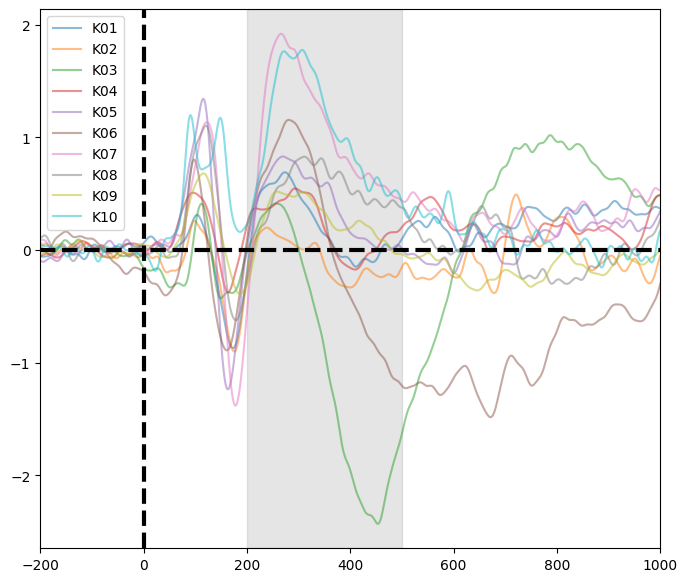

In [24]:
plt.figure(figsize=(8, 7))
for participant in con:
    plt.plot(times, cat_con[participant]['Faces'], label=participant, alpha=0.5)
for participant in AD:
    plt.plot(times, cat_AD[participant]['Faces'], label=participant, alpha=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.axvline(0, color='black', linestyle='--', linewidth=3)
plt.axvspan(200, 500, color='grey', alpha=0.2)
plt.legend()
plt.xlim(-200, 1000)
plt.show()

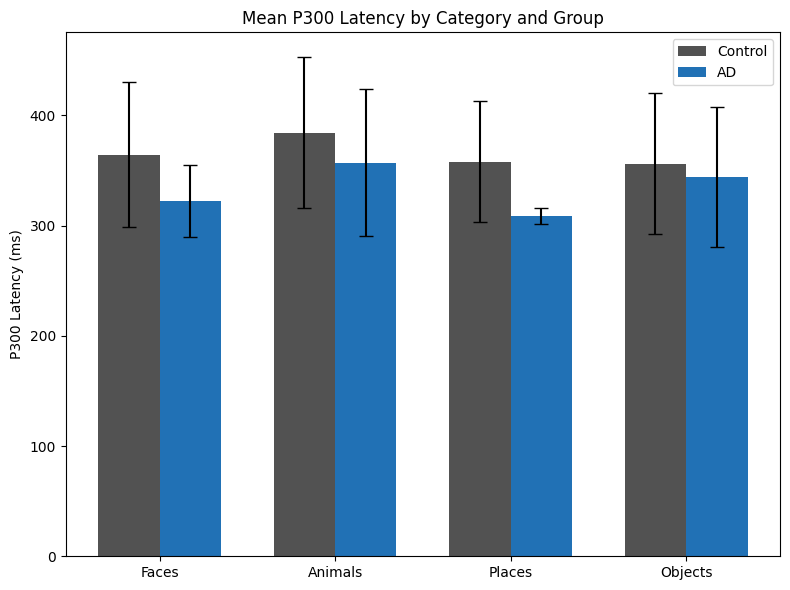

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Store latencies per group and category
con_latencies = {cat: [] for cat in categories_list}
AD_latencies = {cat: [] for cat in categories_list}

# Extract for control group
for participant in con:
    for cat in categories_list:
        cat_erp = cat_con[participant][cat]
        _, lat, _ = extract_p300(cat_erp, times, window=(300, 500))
        con_latencies[cat].append(lat)

# Extract for AD group
for participant in AD:
    for cat in categories_list:
        cat_erp = cat_AD[participant][cat]
        _, lat, _ = extract_p300(cat_erp, times, window=(300, 500))
        AD_latencies[cat].append(lat)


# Compute mean and std for plotting
con_means = [np.mean(con_latencies[cat]) for cat in categories_list]
con_stds = [np.std(con_latencies[cat]) for cat in categories_list]

AD_means = [np.mean(AD_latencies[cat]) for cat in categories_list]
AD_stds = [np.std(AD_latencies[cat]) for cat in categories_list]

x = np.arange(len(categories_list))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, con_means, width, yerr=con_stds, label='Control', capsize=5, color=colour_con[0])
rects2 = ax.bar(x + width/2, AD_means, width, yerr=AD_stds, label='AD', capsize=5, color=colour_AD[0])

# Labels and formatting
ax.set_ylabel('P300 Latency (ms)')
ax.set_title('Mean P300 Latency by Category and Group')
ax.set_xticks(x)
ax.set_xticklabels(categories_list)
ax.legend()

plt.tight_layout()
plt.show()


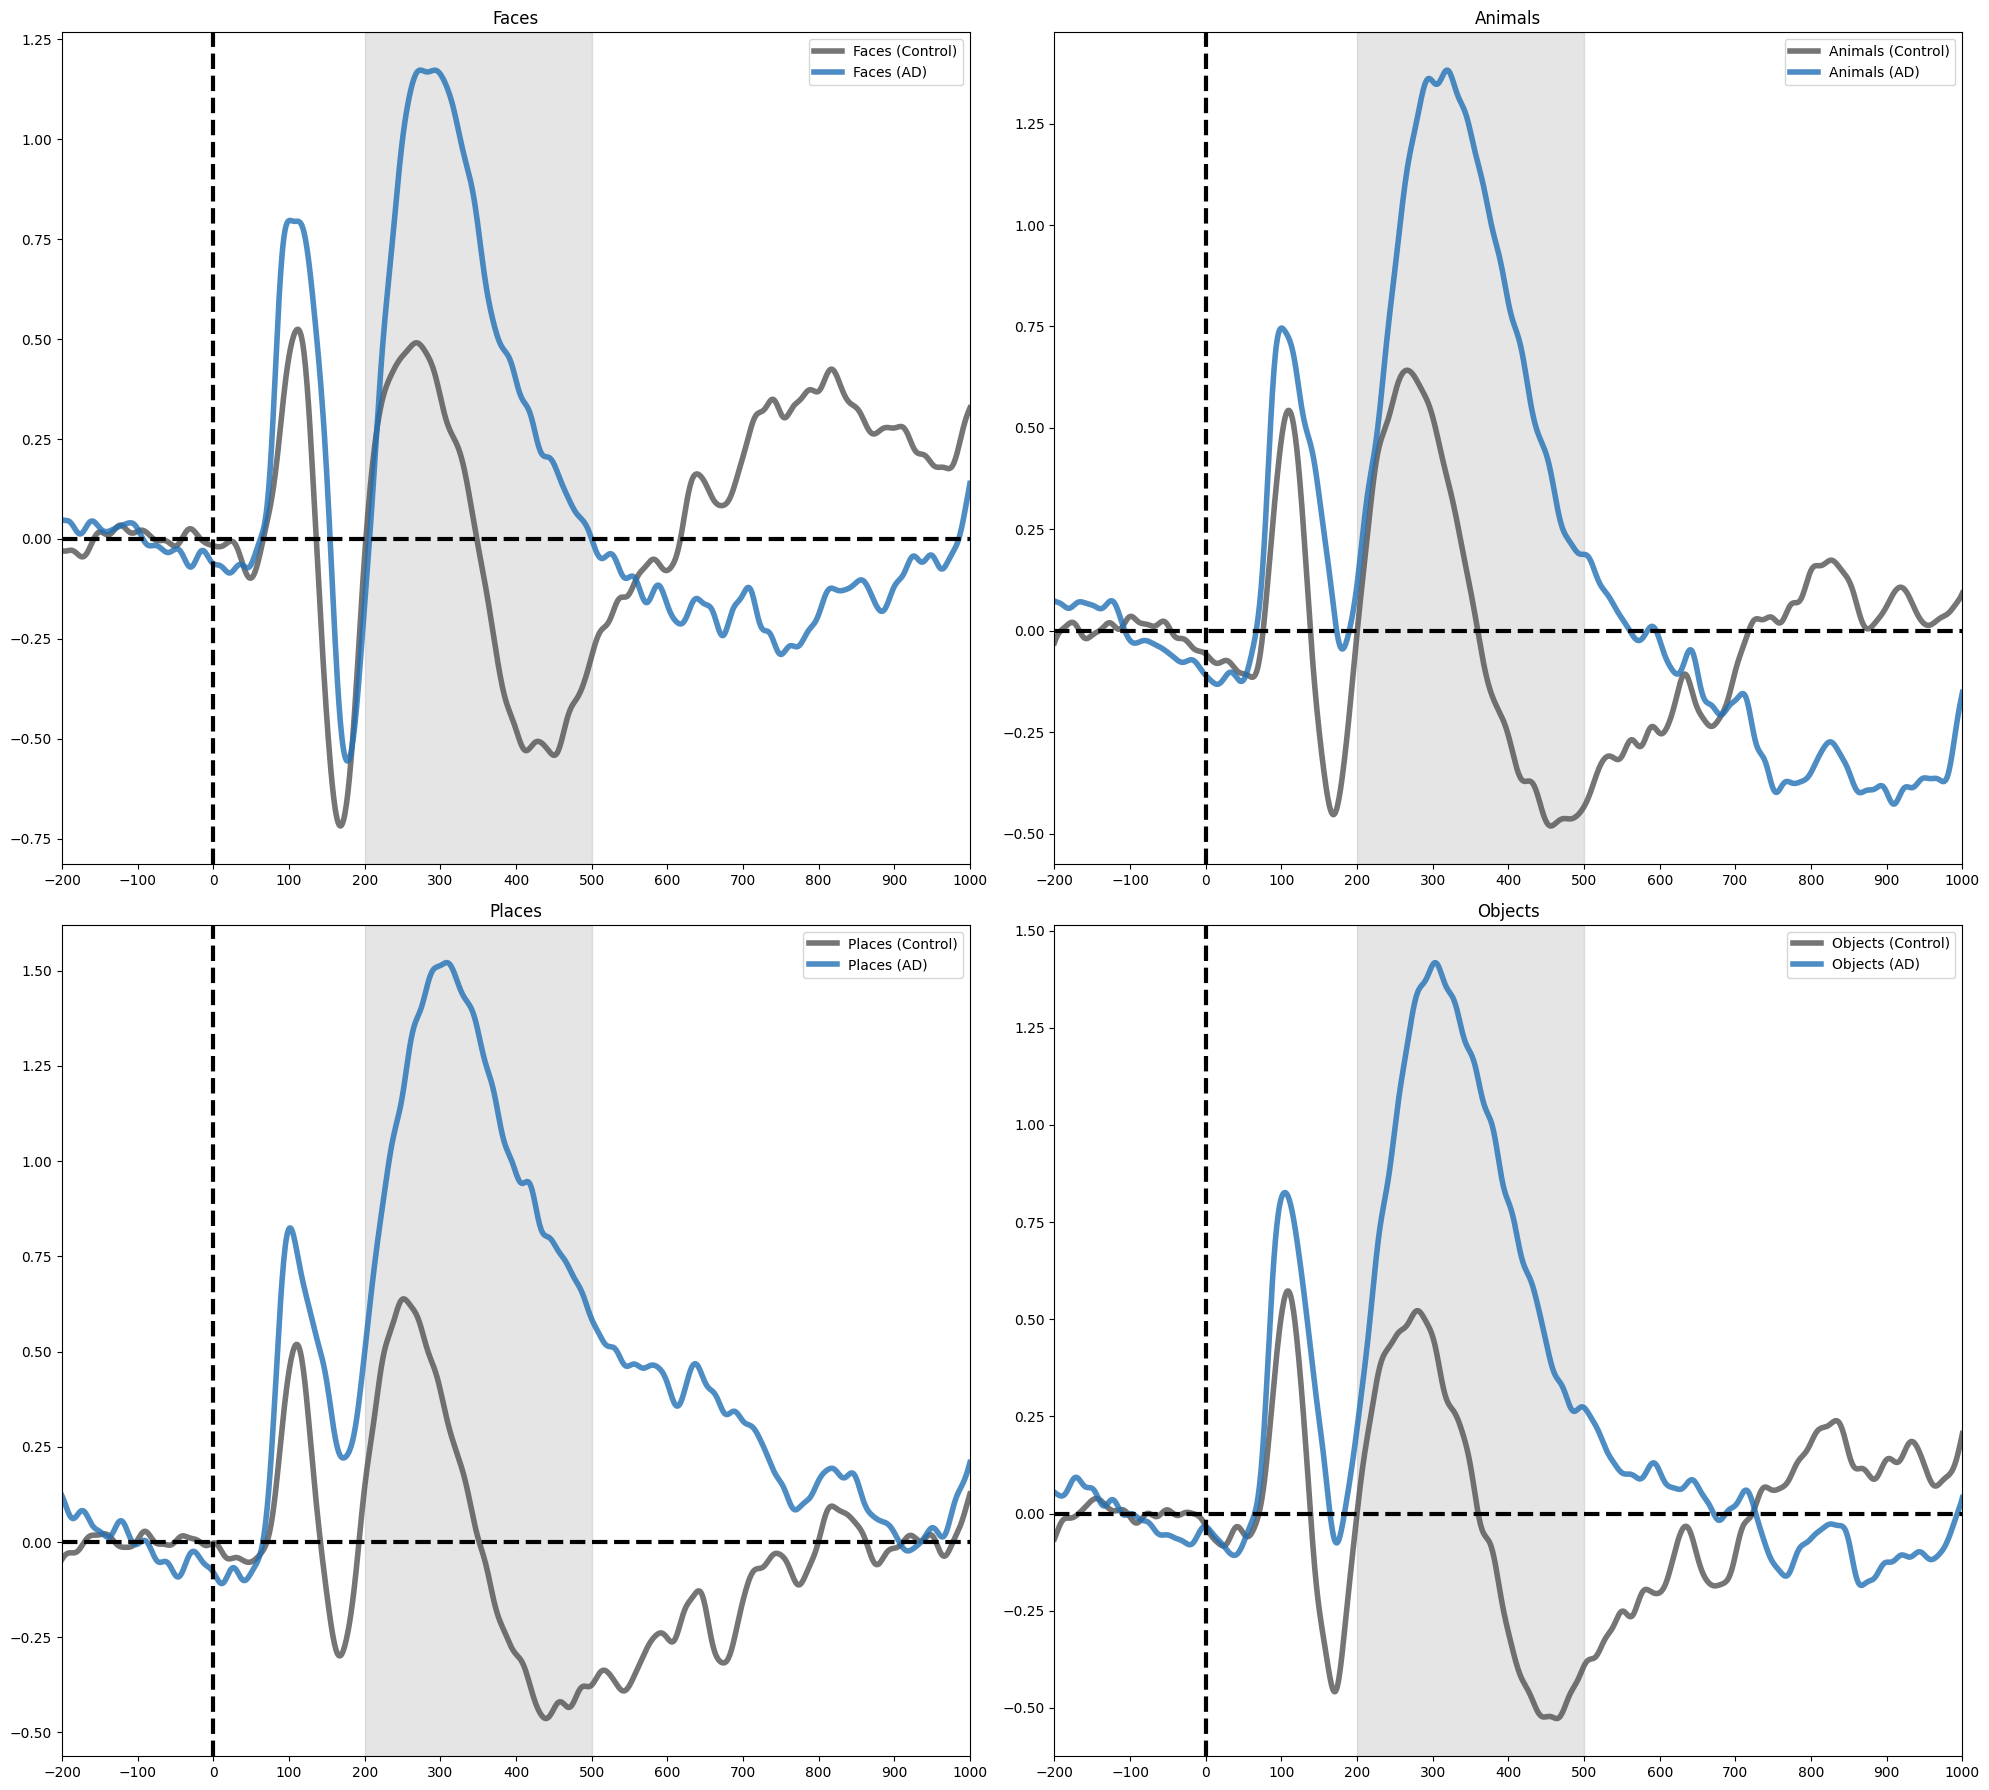

In [28]:
plt.figure(figsize=(20, 18))
for i, category in enumerate(categories_list, 1):
    con_mean = np.mean([cat_con[p][category] for p in con], axis=0)
    AD_mean = np.mean([cat_AD[p][category] for p in AD], axis=0)
    plt.subplot(2, 2, i)
    plt.plot(times, con_mean, label=f'{category} (Control)', alpha=0.8, color=colour_con[0], linewidth=4)
    plt.plot(times, AD_mean, label=f'{category} (AD)', alpha=0.8, color=colour_AD[0], linewidth=4)
    plt.axvspan(200, 500, color='grey', alpha=0.2)
    plt.title(category)
    plt.axvline(0, color='k', linestyle='--', linewidth=3)
    plt.axhline(0, color='k', linestyle='--', linewidth=3)
    plt.legend()
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200, 1001, 100))
    plt.tight_layout()

plt.show()

## Sup

In [54]:
sups = {
    "Animate": range(1, 33),       
    "Inanimate": range(33, 65),    
}
sups_list = ["Animate", "Inanimate"]

erps = {}

for data in out_dict:
    participant = data['subject']
    eeg_data = data['eeg'] #eeg data shape: (n_imgs, n_reps, n_chans, n_times)
    n_imgs = eeg_data.shape[0]
    labels = data['img']
    ch_names = data['chans']

    for category, indices in sups.items():
        n_imgs = len(indices)
        img_mask = np.isin(labels, indices)
        eeg_cat = eeg_data[img_mask]
        #print(eeg_cat.shape)
        erp = np.mean(eeg_cat, axis=(1,2))
        #print(erp.shape)
        erps[(participant, category)] = erp


In [56]:
sup_erps = {}

for key, data in erps.items():
    participant, category = key
    mean_erp = np.mean(data, axis=0)
    cat_erps[(participant, category)] = mean_erp # dictionary with keys for p and cats, then array with 1D already averaged across images

sup_con, sup_AD = {}, {}

for p in con: 
    sup_con[p] = {}
    for cat in sups_list:
        sup_con[p][cat] = cat_erps[(p, cat)]

for p in AD:
    sup_AD[p] = {}
    for cat in sups_list:
        sup_AD[p][cat] = cat_erps[(p, cat)]
    

Extract P300 information (change sup accordingly)

In [61]:
con_amp_mean = []
con_lat = []
con_amp_peak = []

for participant in con:
    sup_erp = sup_con[participant]["Inanimate"]
    amp_mean, lat, amp_peak = extract_p300(sup_erp, times, window=(200,500))

    con_amp_mean.append(amp_mean)
    con_lat.append(lat)
    con_amp_peak.append(amp_peak)

AD_amp_mean = []
AD_lat = []
AD_amp_peak = []

for participant in AD:
    sup_erp = sup_AD[participant]['Inanimate']
    amp_mean, lat, amp_peak = extract_p300(sup_erp, times, window=(200, 500))

    AD_amp_mean.append(amp_mean)
    AD_lat.append(lat)
    AD_amp_peak.append(amp_peak)

print("Individual Control Group P300 Latencies:")
print(np.array(con_lat))
print("Individual Control Group Peak Amplitudes:")
print(np.array(con_amp_peak))
print("\n" + "-"*40 + "\n")
print("Individual AD Group P300 Latencies:")
print(np.array(AD_lat))
print("Individual AD Group Peak Amplitudes:")
print(np.array(AD_amp_peak))
print("\n" + "-"*40 + "\n")

Individual Control Group P300 Latencies:
[254. 222. 242. 212. 267.]
Individual Control Group Peak Amplitudes:
[0.84795693 0.3834234  0.48379494 0.40716545 0.73092132]

----------------------------------------

Individual AD Group P300 Latencies:
[287. 281. 234. 320. 304.]
Individual AD Group Peak Amplitudes:
[1.2858577  1.80943433 0.66504675 0.80686816 2.59803961]

----------------------------------------



In [57]:
import numpy as np
from scipy import stats
n = len(con_lat)
mean_lat_con = np.mean(con_lat)
std_lat_con = np.std(con_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_con / np.sqrt(n))

ci_lower_con = mean_lat_con - moe
ci_upper_con = mean_lat_con + moe


print("Control Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(con_amp_mean):.4f} ± {np.std(con_amp_mean):.4f} µV")
print(f"  Peak Latency   : {np.mean(con_lat):.4f} ± {np.std(con_lat):.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower_con:.4f}, {ci_upper_con:.4f}] ms")
print()
print(f"  Peak Amplitude : {np.mean(con_amp_peak):.4f} ± {np.std(con_amp_peak):.4f} µV")
print()



n = len(AD_lat)
mean_lat_AD = np.mean(AD_lat)
std_lat_AD = np.std(AD_lat, ddof=1)  # use ddof=1 for sample std dev

# Calculate the t critical value for 95% CI
t_crit = stats.t.ppf(1 - 0.025, df=n-1)  # two-tailed 95%

# Calculate the margin of error
moe = t_crit * (std_lat_AD / np.sqrt(n))

ci_lower_AD = mean_lat_AD - moe
ci_upper_AD = mean_lat_AD + moe

print("AD Group P300 Analysis: Grand Average in Parietal Channels")

print("AD Group P300 Analysis:")
print(f"  Mean Amplitude : {np.mean(AD_amp_mean):.4f} ± {np.std(AD_amp_mean):.4f} µV")
print()
print(f"  Peak Latency   : {np.mean(AD_lat):.4f} ± {np.std(AD_lat):.4f} ms")
print(f"95% CI for Peak Latency: [{ci_lower_AD:.4f}, {ci_upper_AD:.4f}] ms")
print()
print(f"  Peak Amplitude : {np.mean(AD_amp_peak):.4f} ± {np.std(AD_amp_peak):.4f} µV")
print()
print()


Control Group P300 Analysis:
  Mean Amplitude : 0.0072 ± 0.4195 µV
  Peak Latency   : 251.0000 ± 18.9420 ms
95% CI for Peak Latency: [224.7043, 277.2957] ms

  Peak Amplitude : 0.5860 ± 0.2134 µV

AD Group P300 Analysis: Grand Average in Parietal Channels
AD Group P300 Analysis:
  Mean Amplitude : 0.7037 ± 0.4353 µV

  Peak Latency   : 301.6000 ± 26.0814 ms
95% CI for Peak Latency: [265.3932, 337.8068] ms

  Peak Amplitude : 1.3586 ± 0.4960 µV




In [62]:
mwu_n170ampmean_sup = mwu_with_r(con_amp_mean, AD_amp_mean, name="Sup P300 Mean Amplitude")
mwu_n170lat_sup = mwu_with_r(con_lat, AD_lat, name="Sup P300 Peak Latency")
mwu_n170peak_sup = mwu_with_r(con_amp_peak, AD_amp_peak, name="Sup P300 Local Peak Amplitude")

Sup P300 Mean Amplitude:
 r=-0.6936, U=2.0, p=0.0317
Sup P300 Peak Latency:
 r=-0.6275, U=3.0, p=0.0556
Sup P300 Local Peak Amplitude:
 r=-0.6275, U=3.0, p=0.0556


Plots for visualisation

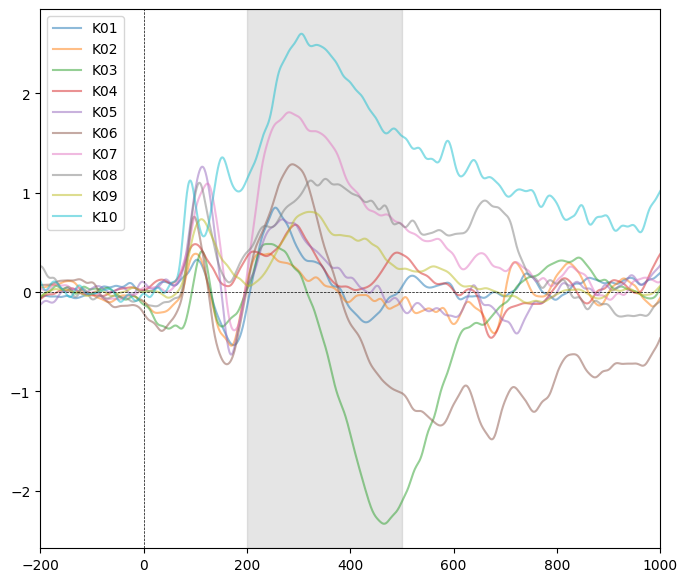

In [64]:
plt.figure(figsize=(8, 7))
for participant in con:
    plt.plot(times, sup_con[participant]['Inanimate'], label=participant, alpha=0.5)
for participant in AD:
    plt.plot(times, sup_AD[participant]['Inanimate'], label=participant, alpha=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvspan(200, 500, color='grey', alpha=0.2)
plt.legend()
plt.xlim(-200, 1000)
plt.show()

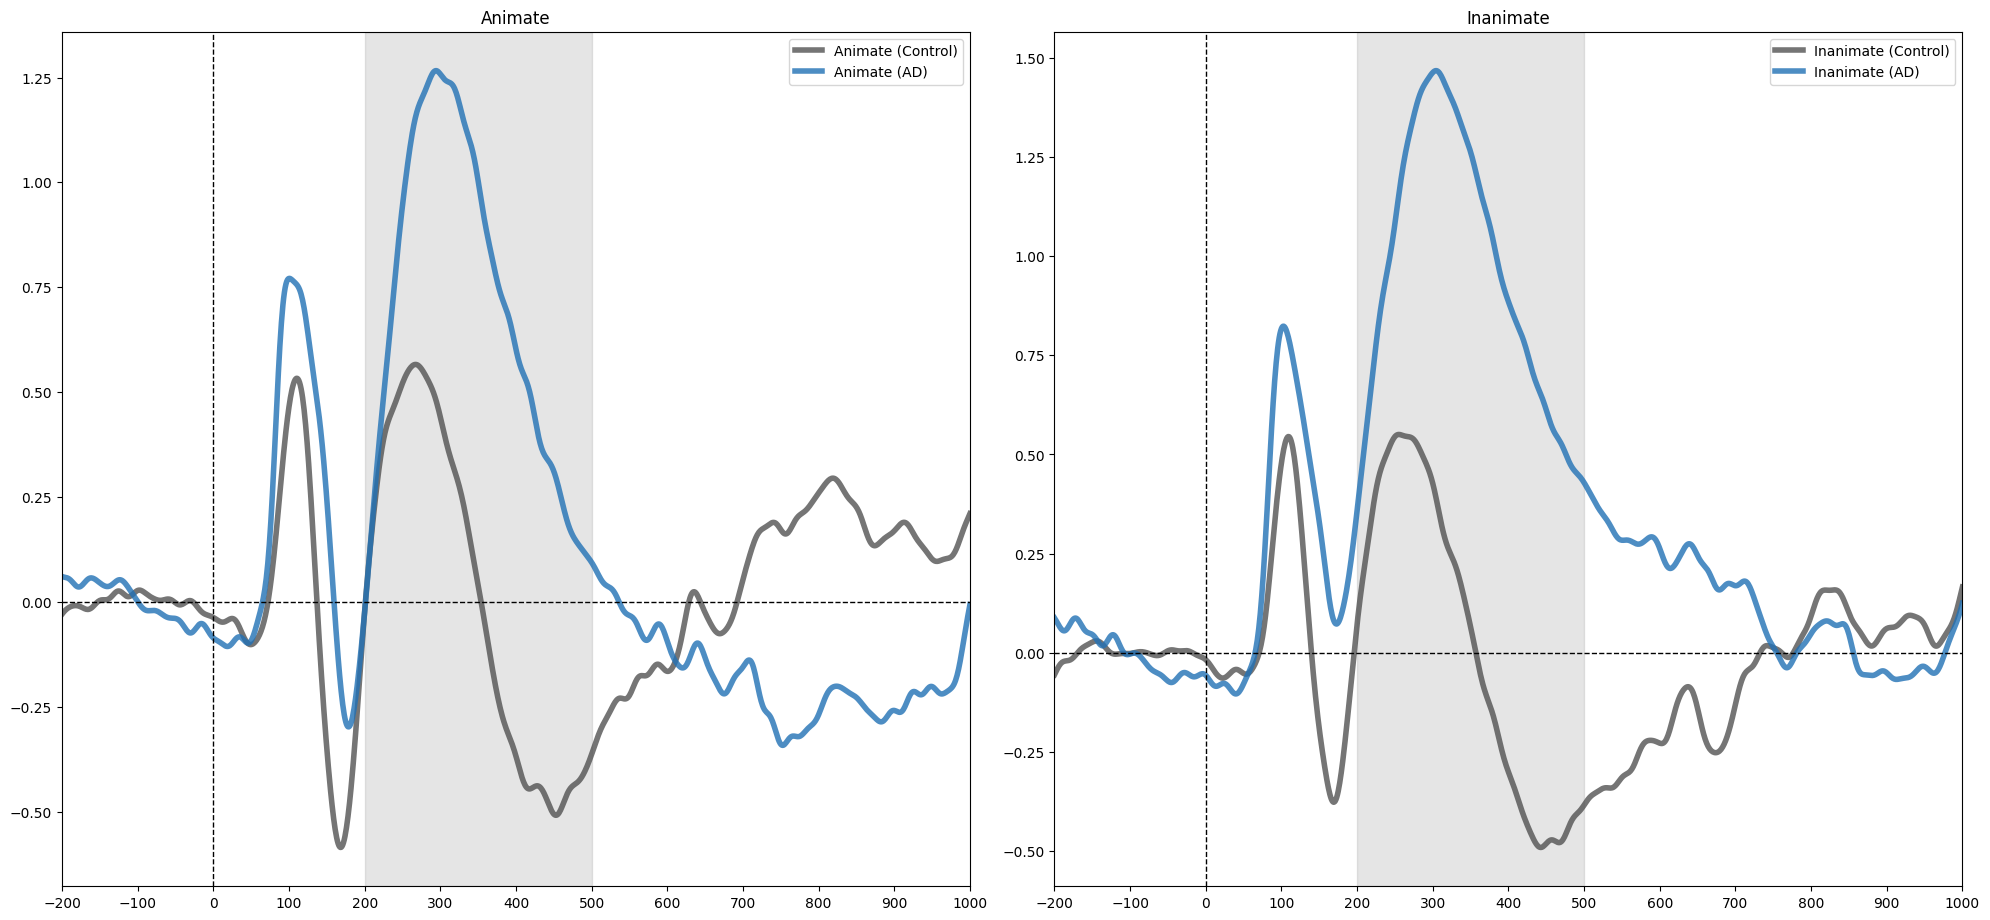

In [65]:
plt.figure(figsize=(20, 18))
for i, category in enumerate(categories_list, 1):
    con_mean = np.mean([sup_con[p][category] for p in con], axis=0)
    AD_mean = np.mean([sup_AD[p][category] for p in AD], axis=0)
    plt.subplot(2, 2, i)
    plt.plot(times, con_mean, label=f'{category} (Control)', alpha=0.8, color=colour_con[0], linewidth=4)
    plt.plot(times, AD_mean, label=f'{category} (AD)', alpha=0.8, color=colour_AD[0], linewidth=4)
    plt.axvspan(200, 500, color='grey', alpha=0.2)
    plt.title(category)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.legend()
    plt.xlim(-200,1000)
    plt.xticks(np.arange(-200, 1001, 100))
    plt.tight_layout()

plt.show()

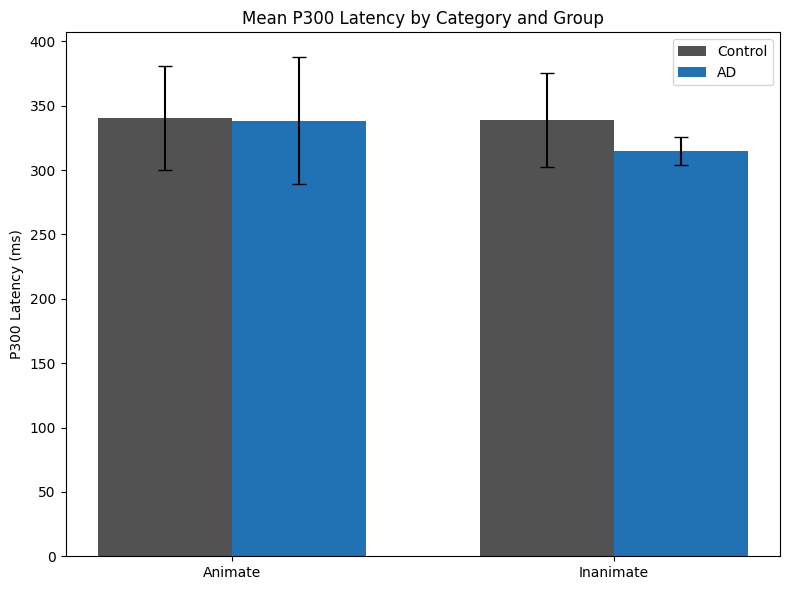

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Store latencies per group and category
con_latencies = {cat: [] for cat in sups_list}
AD_latencies = {cat: [] for cat in sups_list}

# Extract for control group
for participant in con:
    for cat in sups_list:
        cat_erp = sup_con[participant][cat]
        _, lat, _ = extract_p300(cat_erp, times, window=(300, 500))
        con_latencies[cat].append(lat)

# Extract for AD group
for participant in AD:
    for cat in sups_list:
        cat_erp = sup_AD[participant][cat]
        _, lat, _ = extract_p300(cat_erp, times, window=(300, 500))
        AD_latencies[cat].append(lat)

# Compute mean and std for plotting
con_means = [np.mean(con_latencies[cat]) for cat in sups_list]
con_stds = [np.std(con_latencies[cat]) for cat in sups_list]

AD_means = [np.mean(AD_latencies[cat]) for cat in sups_list]
AD_stds = [np.std(AD_latencies[cat]) for cat in sups_list]

x = np.arange(len(sups_list))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, con_means, width, yerr=con_stds, label='Control', capsize=5, color=colour_con[0])
rects2 = ax.bar(x + width/2, AD_means, width, yerr=AD_stds, label='AD', capsize=5, color=colour_AD[0])

# Labels and formatting
ax.set_ylabel('P300 Latency (ms)')
ax.set_title('Mean P300 Latency by Category and Group')
ax.set_xticks(x)
ax.set_xticklabels(sups_list)
ax.legend()

plt.tight_layout()
plt.show()



# Occipital channels